In [ ]:
# prompt: upload file

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


In [ ]:
pip install scipy

In [ ]:
import pandas as pd, numpy as np, seaborn as sns,matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr


In [ ]:
data = pd.read_csv('spotify_dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'spotify_dataset.csv'

In [ ]:
data.head(5)

In [ ]:
unique_counts = data.nunique()
print(unique_counts)

Unnamed: 0          114000
track_id             89741
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50697
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45653
time_signature           5
track_genre            114
dtype: int64


In [ ]:
# ON THE DATASET
total_tracks = len(data)
total_artists = data['artists'].nunique() if 'artists' in data.columns else "N/A"
total_albums = data['album_name'].nunique() if 'album_name' in data.columns else "N/A"
total_genres = data['track_genre'].nunique() if 'track_genre' in data.columns else "N/A"

print("Dataset Overview:")
print(f"- Total Tracks: {total_tracks:,}")
print(f"- Unique Artists: {total_artists}")
print(f"- Unique Albums: {total_albums}")
print(f"- Total Genres: {total_genres}")

Dataset Overview:
- Total Tracks: 114,000
- Unique Artists: 31437
- Unique Albums: 46589
- Total Genres: 114


In [ ]:
#CHECK FOR OUTLIERS
#Checking for outliers in the 'popularity' column using the IQR method
# Outliers are defined as values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]

# Quantile calculation
Q1 = data['popularity'].quantile(0.25)
Q3 = data['popularity'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identify outliers
outliers = data[(data['popularity'] < lower_bound) | (data['popularity'] > upper_bound)]

# Display the number of outliers and some details
num_outliers = len(outliers)
outliers_summary = outliers[['track_name', 'popularity', 'artists', 'track_genre']].head()

print(f"Number of Outliers in Popularity: {num_outliers}")
print("Sample Outliers:")
print(outliers_summary)


#we see that songs are repeating with different genres
##RAN THE CODE AT 3 *IQR & THAT SHOWED 0 OUTLIERS SO WE WILL JUST KEEP THE SONG

Number of Outliers in Popularity: 2
Sample Outliers:
                      track_name  popularity               artists track_genre
20001  Unholy (feat. Kim Petras)         100  Sam Smith;Kim Petras       dance
81051  Unholy (feat. Kim Petras)         100  Sam Smith;Kim Petras         pop


In [ ]:
#MANAGE DUPLICATES: outlier insight shows us that songs are repeating so we need to update dataframe

#cant use song ID so we use combination of track_name & artists to identify songs
#create multi-list for genres
data_unique = data.groupby(['track_name', 'artists'])['track_genre'].apply(lambda x: list(x.unique())).reset_index()

# Merge
# assume features are identical acorss duplicates so we just take the first entry
data_combined = data.drop(columns=['track_genre']).drop_duplicates(subset=['track_name', 'artists'])
data2 = data_combined.merge(data_unique, on=['track_name', 'artists'], how='left')

data2


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,"[acoustic, j-pop, singer-songwriter, songwriter]"
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,"[acoustic, chill]"
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,[acoustic]
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,[acoustic]
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,[acoustic]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81339,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,[world-music]
81340,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,[world-music]
81341,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,[world-music]
81342,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,[world-music]


In [ ]:
#UPDATED INSIGHTS
# ON THE DATASET
total_tracks = len(data2)
total_artists = data2['artists'].nunique() if 'artists' in data2.columns else "N/A"
total_albums = data2['album_name'].nunique() if 'album_name' in data2.columns else "N/A"
#genre - use from earlier

# Count the number of songs with more than one genre
# Ensure genre has lists only, replacing Na with empty lists
data2['track_genre'] = data2['track_genre'].apply(lambda x: x if isinstance(x, list) else [])

multi_genre_songs = data2[data2['track_genre'].apply(len) > 1]
num_multi_genre_songs = len(multi_genre_songs)



print("Dataset Overview:")
print(f"- Total Tracks: {total_tracks:,}")
print(f"- Unique Artists: {total_artists}")
print(f"- Unique Albums: {total_albums}")
print(f"- Total Genres: {total_genres}") #used from earlier
print(f"- No. of Multi Genre songs: {num_multi_genre_songs}")

Dataset Overview:
- Total Tracks: 81,344
- Unique Artists: 31437
- Unique Albums: 45094
- Total Genres: 114
- No. of Multi Genre songs: 13431


In [ ]:
#removing data that doesnt have predictive power
data2.drop(columns=['track_id','artists','album_name', 'track_name', 'Unnamed: 0'], inplace=True)

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81344 entries, 0 to 81343
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        81344 non-null  int64  
 1   duration_ms       81344 non-null  int64  
 2   explicit          81344 non-null  bool   
 3   danceability      81344 non-null  float64
 4   energy            81344 non-null  float64
 5   key               81344 non-null  int64  
 6   loudness          81344 non-null  float64
 7   mode              81344 non-null  int64  
 8   speechiness       81344 non-null  float64
 9   acousticness      81344 non-null  float64
 10  instrumentalness  81344 non-null  float64
 11  liveness          81344 non-null  float64
 12  valence           81344 non-null  float64
 13  tempo             81344 non-null  float64
 14  time_signature    81344 non-null  int64  
 15  track_genre       81344 non-null  object 
dtypes: bool(1), float64(9), int64(5), object

In [ ]:
data2.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,81344.000000,8.134400e+04,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000
mean,34.635966,2.314117e+05,0.559275,0.635025,5.285922,-8.593940,0.632339,0.088992,0.329670,0.184731,0.219721,0.463280,122.145034,3.896968
std,19.438777,1.164945e+05,0.177746,0.258639,3.557612,5.304765,0.482171,0.116628,0.339961,0.331591,0.198271,0.263383,30.128881,0.456396
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.738710e+05,0.446000,0.455000,2.000000,-10.451250,0.000000,0.036100,0.015900,0.000000,0.098500,0.241000,99.408000,4.000000
50%,35.000000,2.152040e+05,0.573000,0.678000,5.000000,-7.262000,1.000000,0.049100,0.190000,0.000089,0.133000,0.449000,122.030000,4.000000
75%,49.000000,2.673460e+05,0.690000,0.857000,8.000000,-5.140000,1.000000,0.087000,0.629000,0.153000,0.283000,0.676000,140.128250,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [ ]:

print(data2.isnull().sum())
#no null rows

popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [ ]:
#creating numerical dataset
data2_num = data2.drop(columns=['track_genre'])

In [ ]:
data2_num

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81339,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
81340,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
81341,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
81342,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


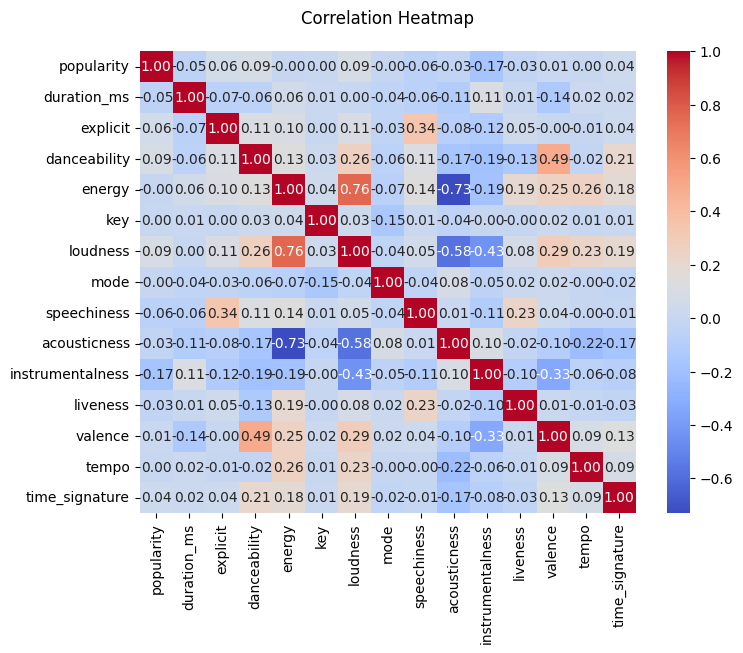

In [ ]:
#CORRELATION MATRIX
correlation_matrix = data2_num.corr()
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', pad=20)
plt.show()
#no collinearity

In [ ]:
data2

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,"[acoustic, j-pop, singer-songwriter, songwriter]"
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,"[acoustic, chill]"
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,[acoustic]
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,[acoustic]
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,[acoustic]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81339,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,[world-music]
81340,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,[world-music]
81341,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,[world-music]
81342,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,[world-music]


In [ ]:


# Convert 'track_genre' (which contains lists) to separate columns for each genre
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(data2['track_genre']), columns=mlb.classes_, index=data2.index)

# merge
data3 = data2.join(genre_dummies).drop(columns=['track_genre'])

# dummify rest
columns_to_dummify = ['key', 'mode', 'explicit', 'time_signature']
data3 = pd.get_dummies(data3, columns=columns_to_dummify, drop_first=True)

# Display the dummified data
# Increase the maximum number of columns to display
pd.set_option('display.max_columns', None)
# Increase the maximum number of rows to display
pd.set_option('display.max_rows', None)
data3.head(5)


,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,comedy,country,dance,dancehall,death-metal,deep-house,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,edm,electro,electronic,emo,folk,forro,french,funk,garage,german,gospel,goth,grindcore,groove,grunge,guitar,happy,hard-rock,hardcore,hardstyle,heavy-metal,hip-hop,honky-tonk,house,idm,indian,indie,indie-pop,industrial,iranian,j-dance,j-idol,j-pop,j-rock,jazz,k-pop,kids,latin,latino,malay,mandopop,metal,metalcore,minimal-techno,mpb,new-age,opera,pagode,party,piano,pop,pop-film,power-pop,progressive-house,psych-rock,punk,punk-rock,r-n-b,reggae,reggaeton,rock,rock-n-roll,rockabilly,romance,sad,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [ ]:
#df without genre
data4 = pd.get_dummies(data2, columns=columns_to_dummify, drop_first=True)
data4 = data4.drop(columns=['track_genre'])


data4.head(5)

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [ ]:
#df for filtering for genre
data5 = pd.get_dummies(data, columns=columns_to_dummify, drop_first=True)
data5.drop(columns=['track_id','artists','album_name', 'track_name', 'Unnamed: 0'], inplace=True)
data5.head(5)

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


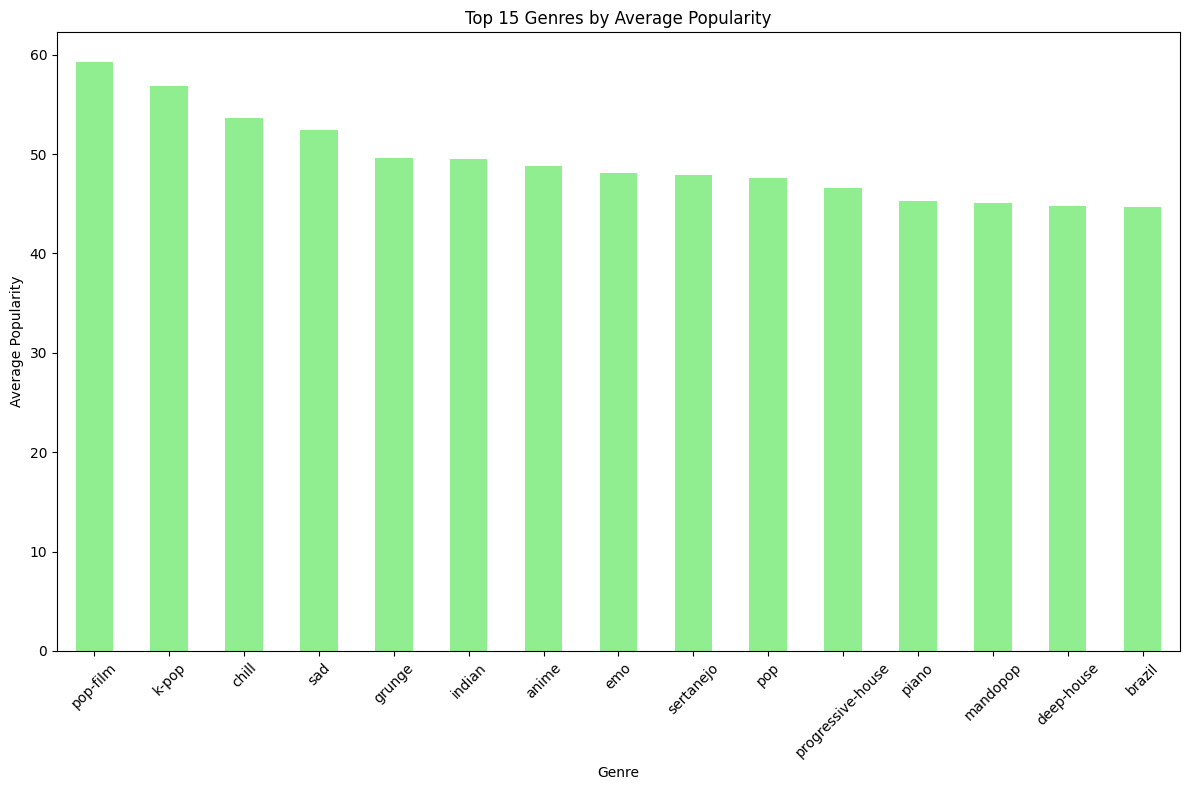


Top 15 Genres by Average Popularity:
track_genre
pop-film             59.283
k-pop                56.896
chill                53.651
sad                  52.379
grunge               49.594
indian               49.539
anime                48.772
emo                  48.128
sertanejo            47.866
pop                  47.576
progressive-house    46.615
piano                45.273
mandopop             45.025
deep-house           44.808
brazil               44.670
electronic           44.325
pagode               44.298
ambient              44.191
british              43.802
metal                43.705
metalcore            43.477
psych-rock           42.778
hard-rock            42.775
acoustic             42.483
dubstep              42.317
world-music          41.873
forro                41.826
gospel               41.639
j-pop                41.143
french               41.067
garage               40.933
mpb                  40.792
turkish              40.698
j-rock               40.66

In [ ]:
###GENRE INSIGHTS - USE ORIGINAL DATA FOR THIS

# Calculate genre counts and average popularity
genre_counts = data['track_genre'].value_counts()
genre_popularity = data.groupby('track_genre')['popularity'].mean().sort_values(ascending=False)

# Plot top 15 genres by average popularity
plt.figure(figsize=(12, 8))
genre_popularity.head(15).plot(kind='bar', color='lightgreen')
plt.title('Top 15 Genres by Average Popularity')
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

print("\nTop 15 Genres by Average Popularity:")
print(genre_popularity)


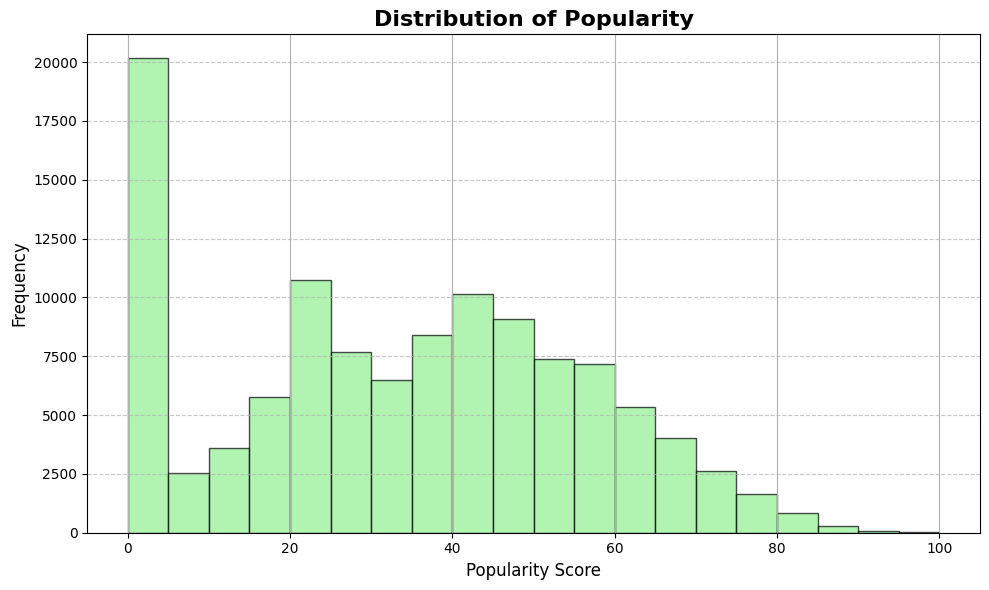

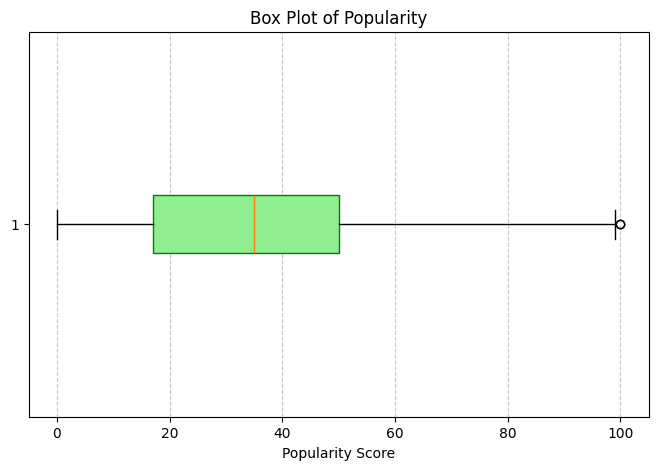

In [ ]:
###LOOKING AT POPULARITY A BIT MORE:

# Plotting a histogram for the 'popularity' feature with improved aesthetics
plt.figure(figsize=(10, 6))
data['popularity'].hist(bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Popularity', fontsize=16, fontweight='bold')
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a light grid for better readability
plt.tight_layout()
plt.show()


#boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(data['popularity'], vert=False, patch_artist=True, boxprops=dict(color="green", facecolor="lightgreen"))
plt.title('Box Plot of Popularity')
plt.xlabel('Popularity Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()




<Figure size 1400x800 with 0 Axes>

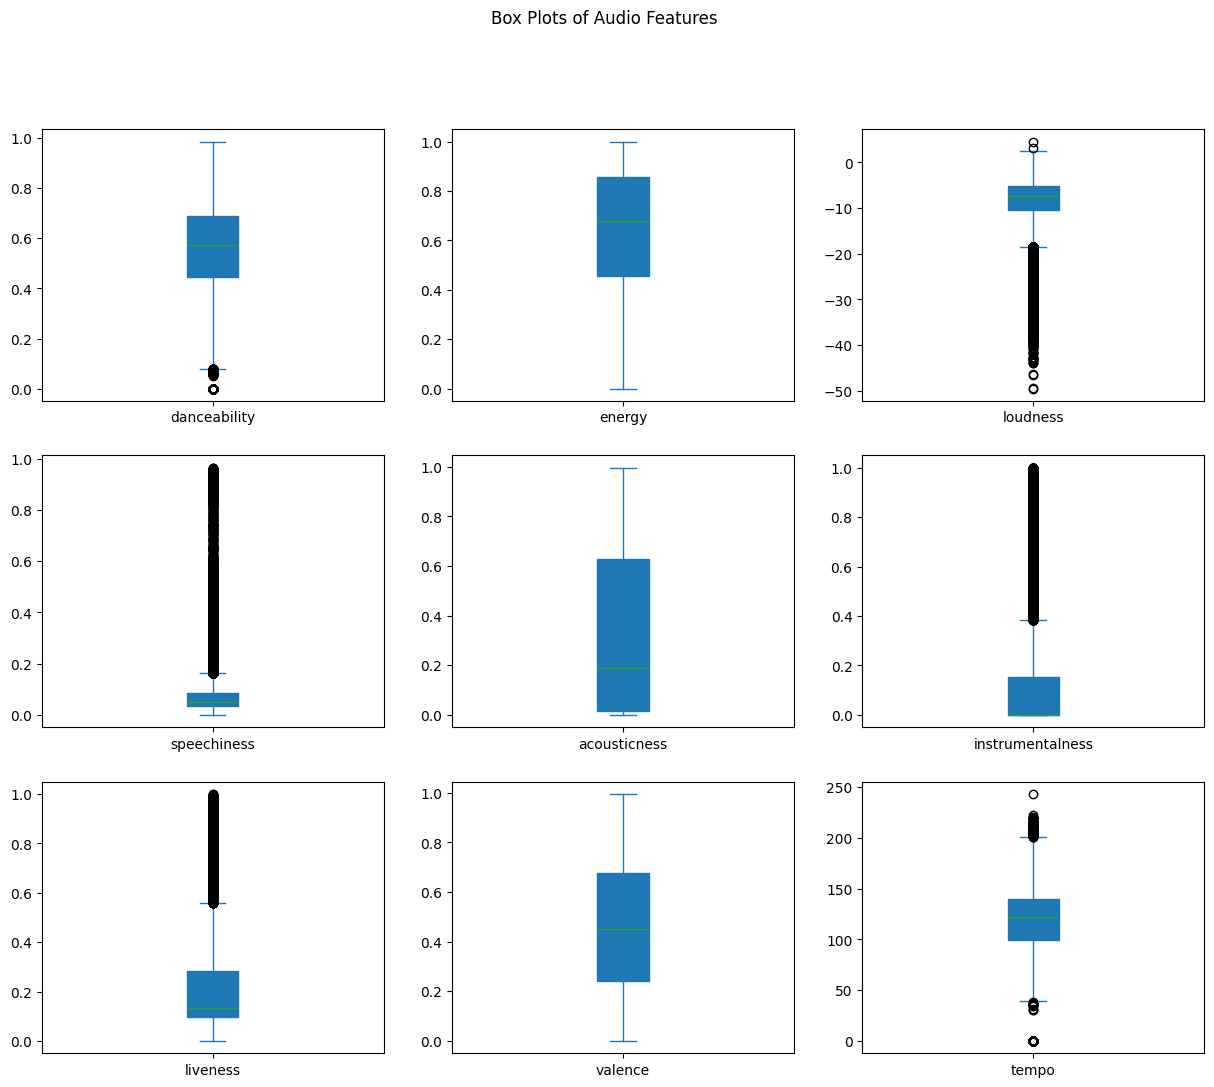

In [ ]:

# audiofeatures
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'tempo']

# box plots
plt.figure(figsize=(14, 8))
data2[audio_features].plot(kind='box', subplots=True, layout=(3, 3), figsize=(15, 12), patch_artist=True)
plt.suptitle('Box Plots of Audio Features')
plt.show()



In [ ]:
#LETS ASSUME TOP 3 GENRES TO BE HIP-HOP, ROCK, POP AND ANALYZE THOSE IF WE WANT TO DO GENRE WISE
#https://www.digitalmusicnews.com/2023/07/22/top-streaming-genres-of-2023-so-far-and-consumption-habits/

Mean Squared Error: 205.93748104369482
R-squared Score: 0.45570683163511905


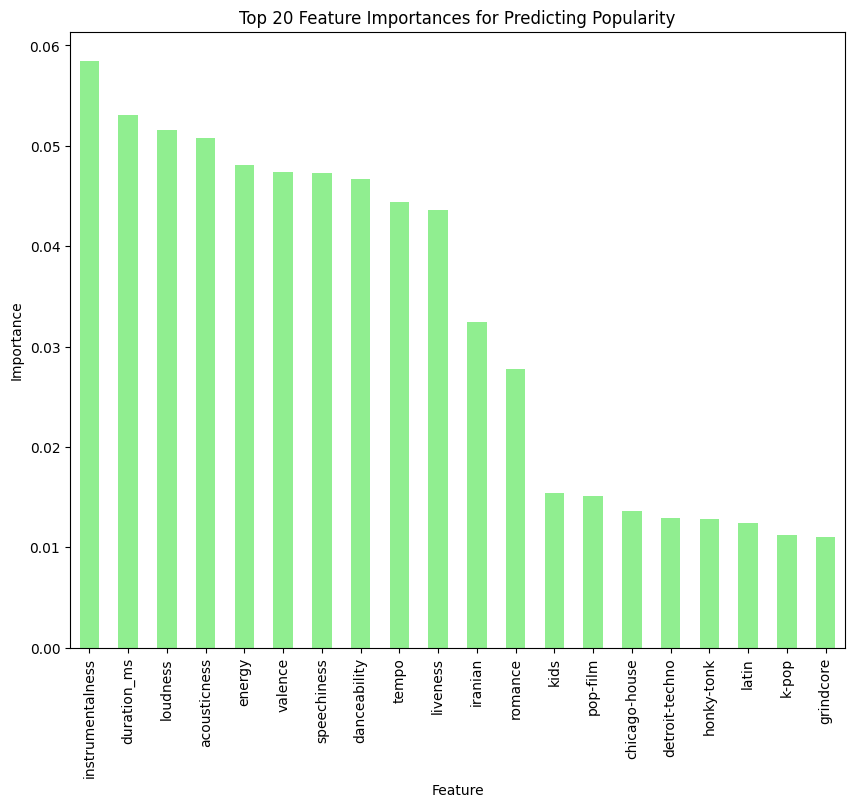

In [ ]:
### RANDOM FOREST FOR FEATURE IMPORTANCE - WITH GENRES

# Define variables
X3 = data3.drop(columns=['popularity'])
y3 = data3['popularity']

# Given we are doing it just for feature importance, reducing n_estimators & don't need to optimize parameters
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
rf_model3 = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model3.fit(X3_train, y3_train)

# Predictions
y3_pred = rf_model3.predict(X3_test)
mse3 = mean_squared_error(y3_test, y3_pred)
r2_3 = r2_score(y3_test, y3_pred)
print(f"Mean Squared Error: {mse3}")
print(f"R-squared Score: {r2_3}")

# Feature importance
feature_importances3 = pd.Series(rf_model3.feature_importances_, index=X3.columns)
feature_importances3 = feature_importances3.sort_values(ascending=False)

# Top features
plt.figure(figsize=(10, 8))
feature_importances3.head(20).plot(kind='bar', color='lightgreen')
plt.title("Top 20 Feature Importances for Predicting Popularity")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


In [ ]:
feature_importances3

,0
instrumentalness,0.058440
duration_ms,0.053083
loudness,0.051561
acousticness,0.050761
energy,0.048089
valence,0.047376
speechiness,0.047299
danceability,0.046736
tempo,0.044415
liveness,0.043604


In [ ]:
# Select the top 15 features
top_15_features = feature_importances3.head(15).index

# Calculate the correlation matrix
corr_matrix = data3[top_15_features + ['popularity']].corr()

# Create the heatmap with shades of green
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['popularity']].drop('popularity'), annot=True, cmap="Greens", fmt=".2f",
            vmin=-1, vmax=1)  # Use 'Greens' colormap
plt.title('Correlation with Popularity (Top 15 Features)')
plt.ylabel('Feature')
plt.show()

KeyError: "None of [Index(['instrumentalnesspopularity', 'duration_mspopularity',\n       'loudnesspopularity', 'acousticnesspopularity', 'energypopularity',\n       'valencepopularity', 'speechinesspopularity', 'danceabilitypopularity',\n       'tempopopularity', 'livenesspopularity', 'iranianpopularity',\n       'romancepopularity', 'kidspopularity', 'pop-filmpopularity',\n       'chicago-housepopularity'],\n      dtype='object')] are in the [columns]"

In [ ]:
threshold = 0.90
cumulative_importance = feature_importances3.cumsum()
selected_features3 = cumulative_importance[cumulative_importance <= threshold].index.tolist()
print(f"Selected Features (90% importance): {selected_features3}")


# Subset the data based on selected features
X3_selected = X3[selected_features3]

len(selected_features3)

Selected Features (90% importance): ['instrumentalness', 'duration_ms', 'loudness', 'acousticness', 'energy', 'valence', 'speechiness', 'danceability', 'tempo', 'liveness', 'iranian', 'romance', 'kids', 'pop-film', 'chicago-house', 'detroit-techno', 'honky-tonk', 'latin', 'k-pop', 'grindcore', 'idm', 'chill', 'classical', 'pop', 'tango', 'breakbeat', 'dance', 'rock', 'happy', 'afrobeat', 'explicit_True', 'black-metal', 'party', 'opera', 'mode_1', 'bluegrass', 'alternative', 'j-dance', 'j-idol', 'country', 'disney', 'hip-hop', 'metal', 'grunge', 'jazz', 'heavy-metal', 'power-pop', 'sad', 'house', 'indie-pop', 'guitar', 'salsa', 'key_1', 'key_9', 'key_7', 'soul', 'anime', 'key_5', 'hardstyle', 'key_2', 'sleep', 'alt-rock', 'key_6', 'goth', 'indie', 'key_4', 'key_11', 'electro', 'malay', 'comedy', 'drum-and-bass', 'key_10', 'hard-rock', 'piano', 'funk']


75

In [ ]:
### RANDOM FOREST FOR FEATURE IMPORTANCE - WITHOUT GENRE

# Define variables
X4 = data4.drop(columns=['popularity'])
y4 = data4['popularity']

# Given we are doing it just for feature importance, reducing n_estimators & don't need to optimize parameters
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
rf_model4 = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model4.fit(X4_train, y4_train)

# Predictions
y4_pred = rf_model4.predict(X4_test)
mse4 = mean_squared_error(y4_test, y4_pred)
r2_4 = r2_score(y4_test, y4_pred)
print(f"Mean Squared Error: {mse4}")
print(f"R-squared Score: {r2_4}")

# Feature importance
feature_importances4 = pd.Series(rf_model4.feature_importances_, index=X4.columns)
feature_importances4 = feature_importances4.sort_values(ascending=False)

# Top features
plt.figure(figsize=(10, 8))
feature_importances4.head(20).plot(kind='bar', color='lightgreen')
plt.title("Top 20 Feature Importances for Predicting Popularity (Without Genre)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()




KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example dataset
X3 = data3.drop(columns=['popularity'])
y3 = data3['popularity']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
rf_model3 = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model3.fit(X3_train, y3_train)

# Hyperparameter grid
n_estimators = [50, 100, 150]       # Number of trees in the forest
max_depth = [10, 20, None]          # Maximum depth of the tree
min_samples_split = [2, 5, 10]      # Minimum samples required to split an internal node

# Variable to track the best model
best_model = None
lowest_mse = float("inf")
best_params = {}

# Tuning loop
for n in n_estimators:
    for depth in max_depth:
        for min_split in min_samples_split:
            # Create and train the model
            model = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                min_samples_split=min_split,
                random_state=42
            )
            model.fit(X3_train, y3_train)

            # Predictions and evaluation
            y_pred = model.predict(X3_test)
            mse = mean_squared_error(y3_test, y_pred)

            # Update the best model if necessary
            if mse < lowest_mse:
                lowest_mse = mse
                best_model = model
                best_params = {
                    "n_estimators": n,
                    "max_depth": depth,
                    "min_samples_split": min_split
                }

# Results
print("Lowest MSE:", lowest_mse)
print("Best Parameters:", best_params)

Lowest MSE: 202.47717624395315
Best Parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 10}


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

X3 = data3.drop(columns=['popularity'])
y3 = data3['popularity']

X3_train_full, X3_test, y3_train_full, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train_full)
X3_test_scaled = scaler.transform(X3_test)

# Feature selection with LassoCV
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X3_train_scaled, y3_train_full)

# Get the indices of the features with non-zero coefficients
selected_features = np.where(lasso.coef_ != 0)[0]
print(f"Number of selected features: {len(selected_features)}")

# Reduce the dataset to the selected features
X3_train_selected = X3_train_scaled[:, selected_features]
X3_test_selected = X3_test_scaled[:, selected_features]

# Cross-validation
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_train_selected, y3_train_full, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt'],  # With fewer features, 'sqrt' may suffice
    'bootstrap': [True]
}

rf_model3 = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model3,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X3_train, y3_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
lowest_mse = -grid_search.best_score_

# Evaluate the best model on the validation data
y_val_pred = best_model.predict(X3_val)
val_mse = mean_squared_error(y3_val, y_val_pred)

# Evaluate on the test data
y_test_pred = best_model.predict(X3_test_selected)
test_mse = mean_squared_error(y3_test, y_test_pred)

# Results
print("Best Parameters:", best_params)
print("Lowest MSE from cross-validation:", lowest_mse)
print("Validation set MSE:", val_mse)
print("Test set MSE:", test_mse)

In [ ]:
# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the feature names for the selected features
selected_feature_names = X3.columns[selected_features]

# Display the feature importances
print("Feature Importances:")
for i in sorted_indices:
    print(f"{selected_feature_names[i]}: {feature_importances[i]:.4f}")

# Adjust figure height dynamically based on the number of features
fig_height = len(sorted_indices) * 0.2  # Scale height per feature
plt.figure(figsize=(10, fig_height))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [selected_feature_names[i] for i in sorted_indices])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [ ]:
# Get the top 10% of songs based on popularity
threshold = np.percentile(y3, 90)  # 90th percentile
top_10_percent_indices = y3 >= threshold
top_10_percent_data = X3[top_10_percent_indices]

# Filter features with importance above 0.02
important_features_indices = sorted_indices[feature_importances[sorted_indices] > 0.02]
important_feature_names = [selected_feature_names[i] for i in important_features_indices]

# Calculate the average values of these features for the top 10% songs
average_values = top_10_percent_data[important_feature_names].mean()

# Calculate the correlation between each feature and popularity
correlations = {}
for feature in important_feature_names:
    correlation = np.corrcoef(X3[feature], y3)[0, 1]
    correlations[feature] = correlation

# Display results
print("Average Values for Top 10% Songs by Popularity:")
print(average_values)

print("\nCorrelation with Popularity (positive or negative):")
for feature, correlation in correlations.items():
    direction = "positive" if correlation > 0 else "negative"
    print(f"{feature}: {correlation:.4f} ({direction})")

In [ ]:
feature_importances4





,0
acousticness,0.108880
duration_ms,0.099844
speechiness,0.092932
danceability,0.092590
instrumentalness,0.092429
loudness,0.090471
valence,0.089242
tempo,0.086388
energy,0.084727
liveness,0.081234


In [ ]:
#RUNNING KMEANS WITH SELECTED FEATURES

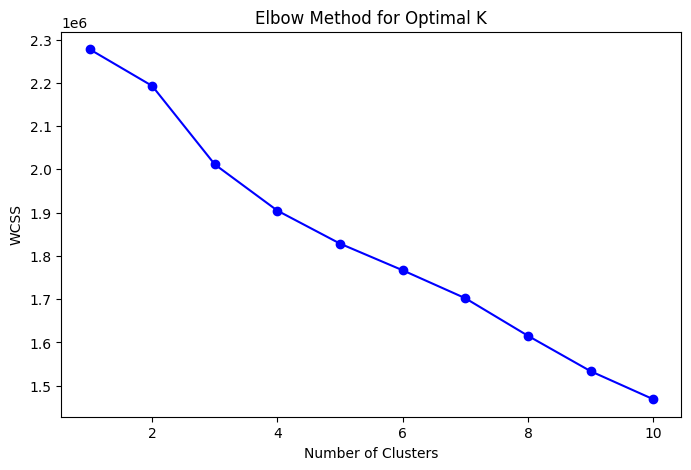

In [ ]:
# Step 1: Subset the data to only include selected features
X_selected = data3[selected_features]  # Assuming data3 is the dataframe with all features

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Step 3: Determine the optimal number of clusters using the elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 4: Fit KMeans with the optimal number of clusters (e.g., if you choose k=5 based on the elbow plot)
optimal_k = 5  # replace with the actual optimal k based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Step 5: Add the cluster labels to your dataset
data3['Cluster_Label'] = clusters

# Display the first few rows to check
print(data3[['Cluster_Label'] + selected_features].head())


In [ ]:
# Standardize
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3_selected)

# Determine the optimal number of clusters using the elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X3_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()



NameError: name 'StandardScaler' is not defined

In [ ]:
# KMEANS - DATA3 - K = 4 BASED ON ABOVE CLUSTERS
optimal_k = 4  # Update this based on the elbow plot results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X3_scaled)

# Add the cluster labels back to the original data3
data3['Cluster_Label'] = clusters

# Display the first few rows of data3 with cluster labels
print(data3[['Cluster_Label'] + selected_features3].head())

   Cluster_Label  instrumentalness  duration_ms  loudness  acousticness  \
0              0          0.000001       230666    -6.746        0.0322   
1              3          0.000006       149610   -17.235        0.9240   
2              3          0.000000       210826    -9.734        0.2100   
3              3          0.000071       201933   -18.515        0.9050   
4              0          0.000000       198853    -9.681        0.4690   

   energy  valence  speechiness  danceability    tempo  liveness  iranian  \
0  0.4610    0.715       0.1430         0.676   87.917    0.3580        0   
1  0.1660    0.267       0.0763         0.420   77.489    0.1010        0   
2  0.3590    0.120       0.0557         0.438   76.332    0.1170        0   
3  0.0596    0.143       0.0363         0.266  181.740    0.1320        0   
4  0.4430    0.167       0.0526         0.618  119.949    0.0829        0   

   romance  kids  pop-film  chicago-house  detroit-techno  honky-tonk  latin  \
0     

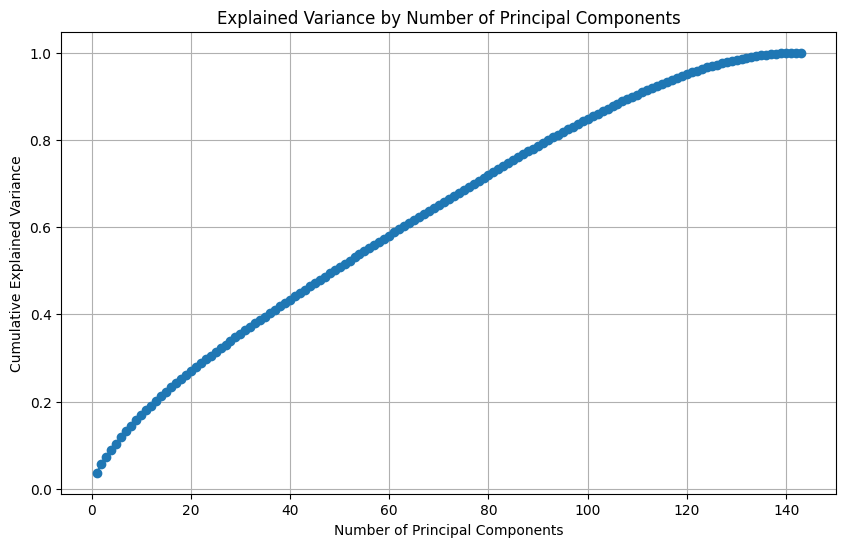

Optimal number of components to retain 90% of variance: 110


,PCA1,PCA2
Cluster_Label,0.383471,0.068739
Cluster,0.348620,0.038110
acousticness,0.324633,0.088731
time_signature_3,0.196380,0.009413
instrumentalness,0.173634,-0.091091
sleep,0.121903,-0.015133
new-age,0.104586,-0.006833
ambient,0.101032,-0.003851
classical,0.089146,0.005758
opera,0.083718,-0.000507


In [ ]:


X3 = data3.drop(columns=['popularity'])

# Standardize the data
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

# Apply PCA
pca = PCA()  # Initialize PCA without specifying components to explore explained variance
X3_pca = pca.fit_transform(X3_scaled)

# Explained Variance Plot (Scree Plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

# Determine the number of components that explain 90% of variance
threshold = 0.90
cumulative_variance = pca.explained_variance_ratio_.cumsum()
num_components = (cumulative_variance >= threshold).argmax() + 1
print(f"Optimal number of components to retain 90% of variance: {num_components}")

# Re-run PCA with the optimal number of components
pca_optimal = PCA(n_components=num_components)
X3_pca_optimal = pca_optimal.fit_transform(X3_scaled)


# Create a DataFrame of the component loadings
# Each column represents a principal component (PCA1, PCA2, etc.)
# Each row represents a feature and its contribution to each component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PCA{i+1}' for i in range(pca.n_components_)], index=X3.columns)

# Display loadings for PCA1 and PCA2
loadings[['PCA1', 'PCA2']].sort_values(by=['PCA1', 'PCA2'], ascending=False)


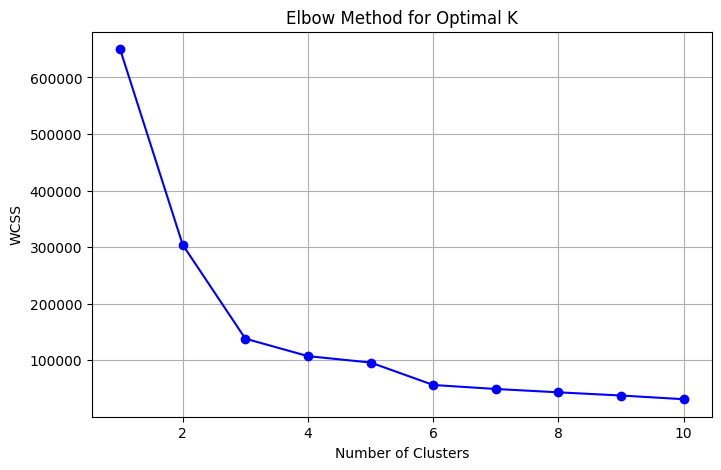

In [ ]:

X3 = data3.drop(columns=['popularity'])

# standardize
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

pca = PCA(n_components=2)  # Using 2 components for visualization
X3_pca = pca.fit_transform(X3_scaled)

# elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X3_pca)
    wcss.append(kmeans.inertia_)

# Plot WCSS for the elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()



In [ ]:
# chosen 3 clusters to show where the major dip is
optimal_k = 3
kmeans= KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X3_scaled)
X3_kmeans = kmeans_optimal.fit_predict(X3_pca)

# Add the cluster labels back to the original data3
data3['Cluster_Label'] = clusters



In [ ]:
# Plot the clusters based on PCA components
plt.figure(figsize=(10, 6))
plt.scatter(X3_pca[:, 0], X3_pca[:, 1], c=X3_kmeans, cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clusters on PCA Components')
plt.legend()
plt.grid(True)
plt.show()


###DOESNT MAKE TOO MUCH SENSE ON THIS LEVEL###########
####LOOK AT IT WITHOUT GENRE#########################

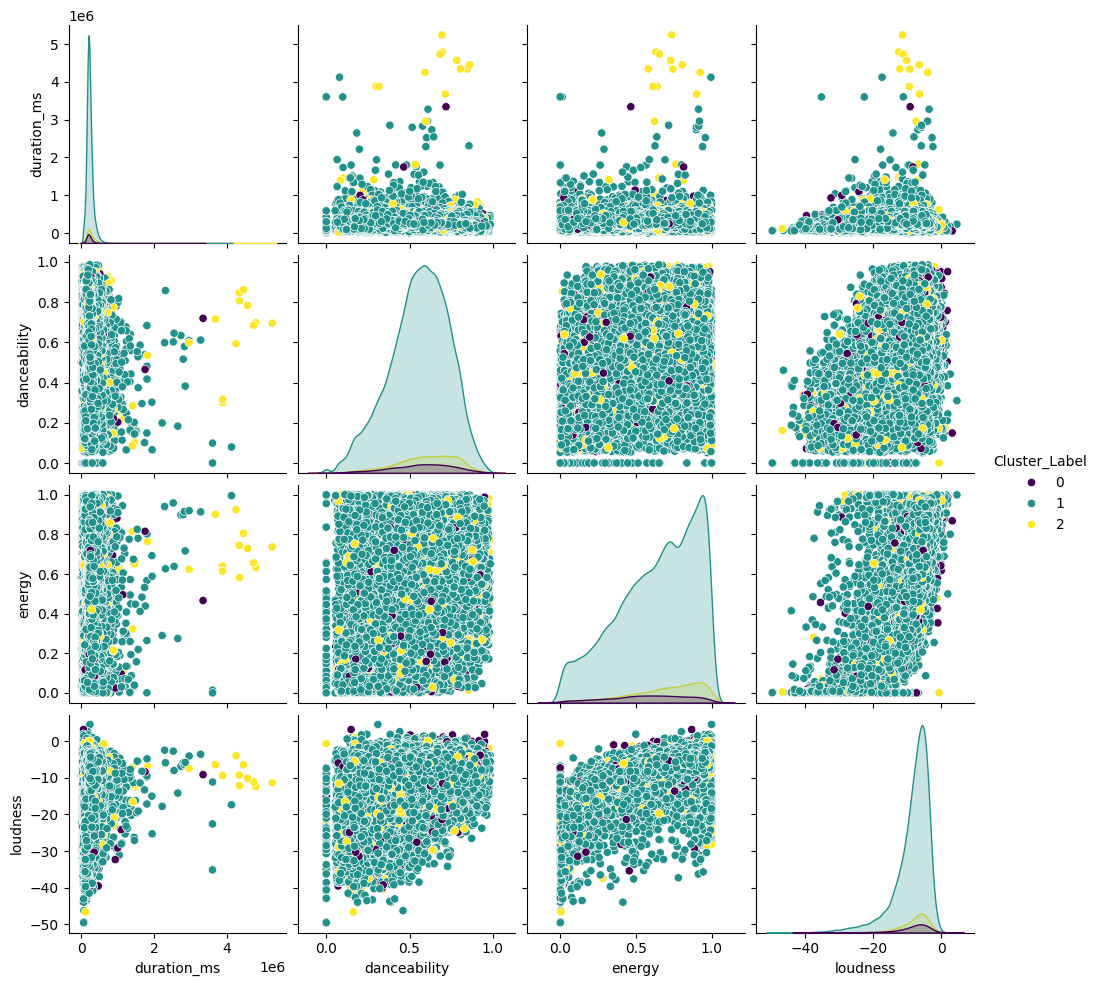

In [ ]:
X3 = data3.drop(columns=['popularity'])

# Standardize all features
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

#
kmeans3 = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
data3['Cluster_Label'] = kmeans3.fit_predict(X3_scaled)

# Use a subset of features for pair plot visualization
selected_features = X3.columns[:4]
sns.pairplot(data3[selected_features.tolist() + ['Cluster_Label']], hue='Cluster_Label', palette='viridis')
plt.show()

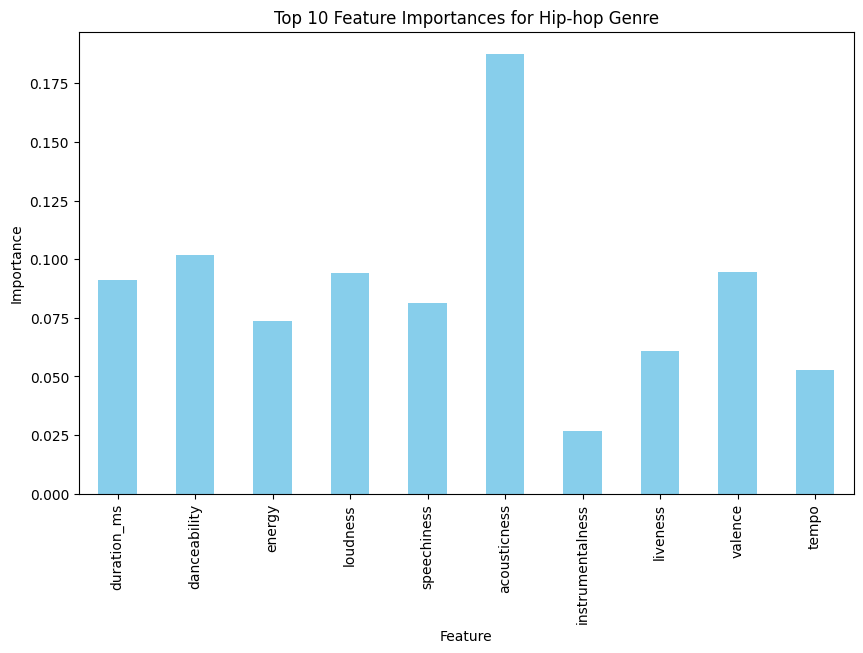

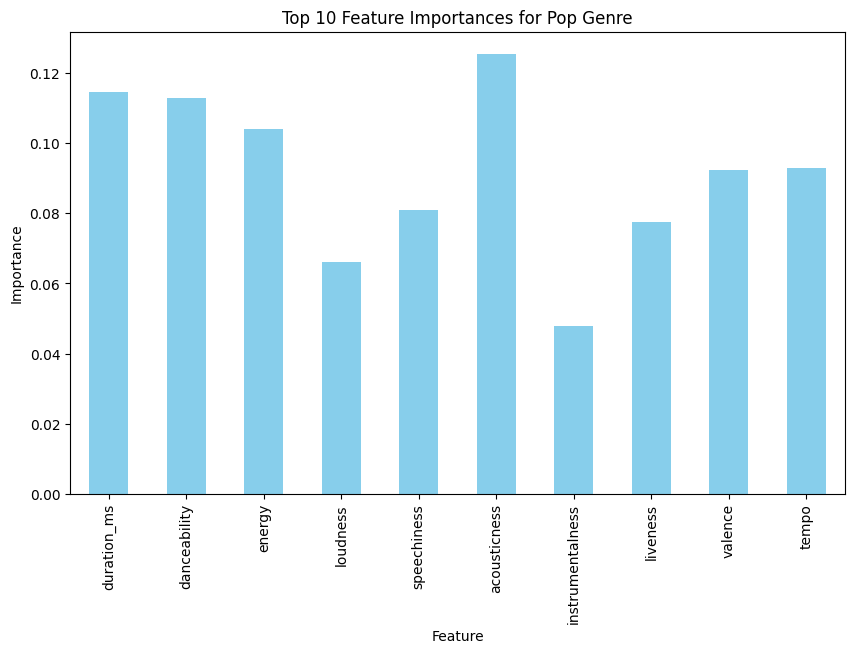

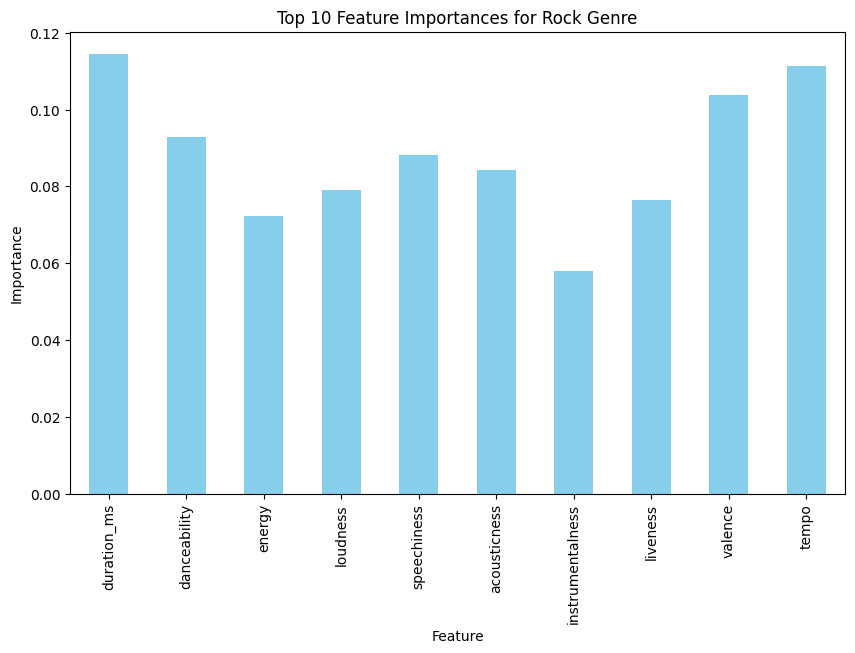

{'hip-hop': acousticness        0.187649
 danceability        0.101758
 valence             0.094734
 loudness            0.094197
 duration_ms         0.090978
 speechiness         0.081424
 energy              0.073849
 explicit_True       0.061804
 liveness            0.060941
 tempo               0.052749
 instrumentalness    0.026604
 key_3               0.011291
 mode_1              0.008899
 key_1               0.007526
 key_9               0.006978
 key_10              0.005717
 key_2               0.005172
 key_5               0.005171
 key_11              0.004247
 key_6               0.003710
 time_signature_4    0.003596
 key_7               0.003272
 key_4               0.003078
 key_8               0.002962
 time_signature_5    0.001110
 time_signature_3    0.000571
 time_signature_1    0.000012
 dtype: float64,
 'pop': acousticness        0.125562
 duration_ms         0.114728
 danceability        0.112906
 energy              0.104044
 tempo               0.092860
 vale

In [ ]:
 ####RANDOMFOREST FOR TOP 3 GENRES

# Selected genres for analysis
selected_genres = ['hip-hop', 'pop', 'rock']
##LETS ASSUME TOP 3 GENRES TO BE HIP-HOP, ROCK, POP
#https://www.digitalmusicnews.com/2023/07/22/top-streaming-genres-of-2023-so-far-and-consumption-habits/


feature_importances_by_genre = {}

# Loop through each genre, filter data, and calculate feature importance
for genre in selected_genres:
    # Filter data for the current genre
    genre_data = data5[data5['track_genre'] == genre]

    # Define X and y
    X = genre_data.drop(columns=['popularity', 'track_genre'])  # Drop target and genre columns
    y = genre_data['popularity']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the random forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Calculate feature importances and store them
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    feature_importances_by_genre[genre] = feature_importances.sort_values(ascending=False)

    # Plot top 10 features for the current genre
    plt.figure(figsize=(10, 6))
    feature_importances.head(10).plot(kind='bar', color='skyblue')
    plt.title(f"Top 10 Feature Importances for {genre.capitalize()} Genre")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

# Display feature importances for each genre
feature_importances_by_genre

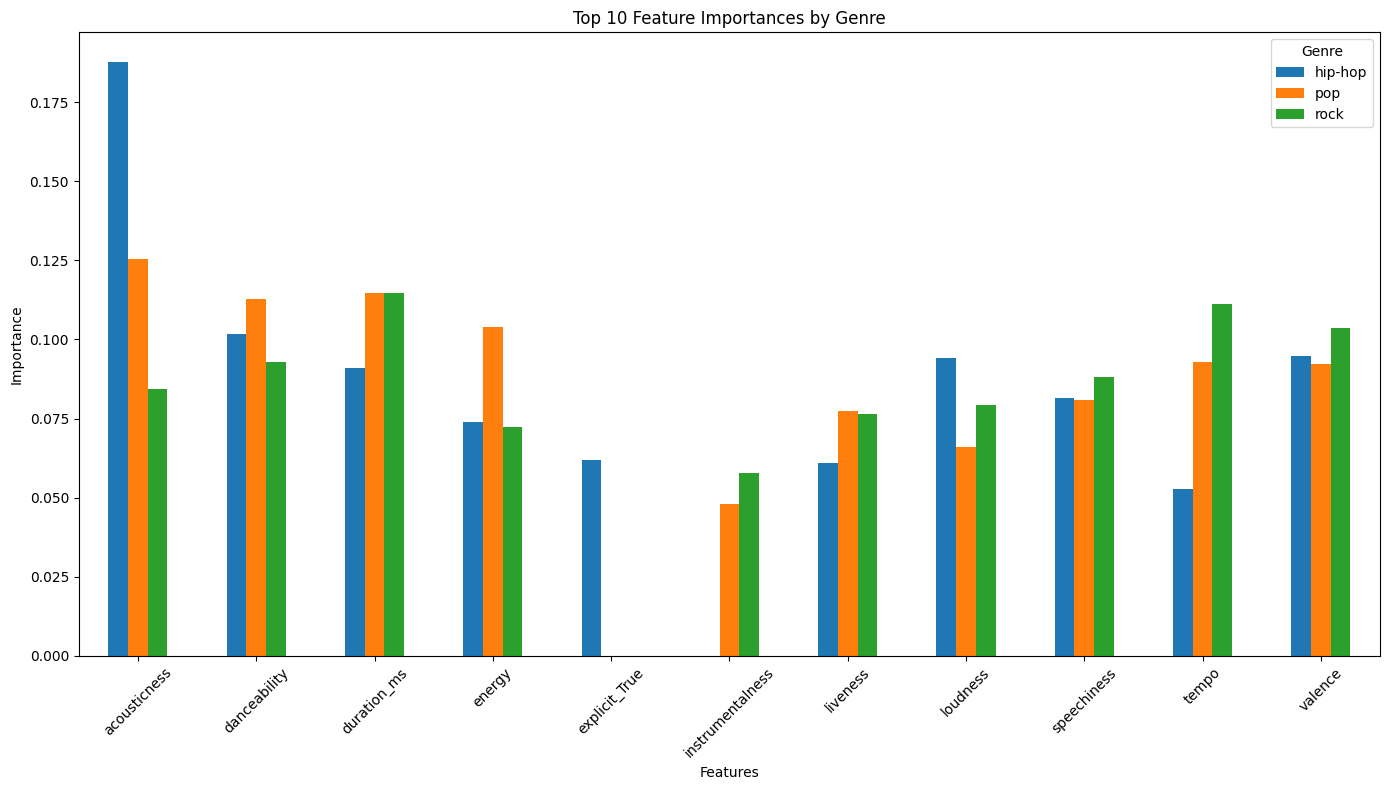

In [ ]:
####TOP 3 GENRES RANDOM FOREST - TOP FEATURES COMPARISON
top_n = 10


top_features_df = pd.DataFrame({
    genre: feature_importances_by_genre[genre].head(top_n)
    for genre in selected_genres
})

# plot
top_features_df.plot(kind='bar', figsize=(14, 8))
plt.title(f"Top {top_n} Feature Importances by Genre")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.legend(title="Genre")
plt.tight_layout()
plt.show()


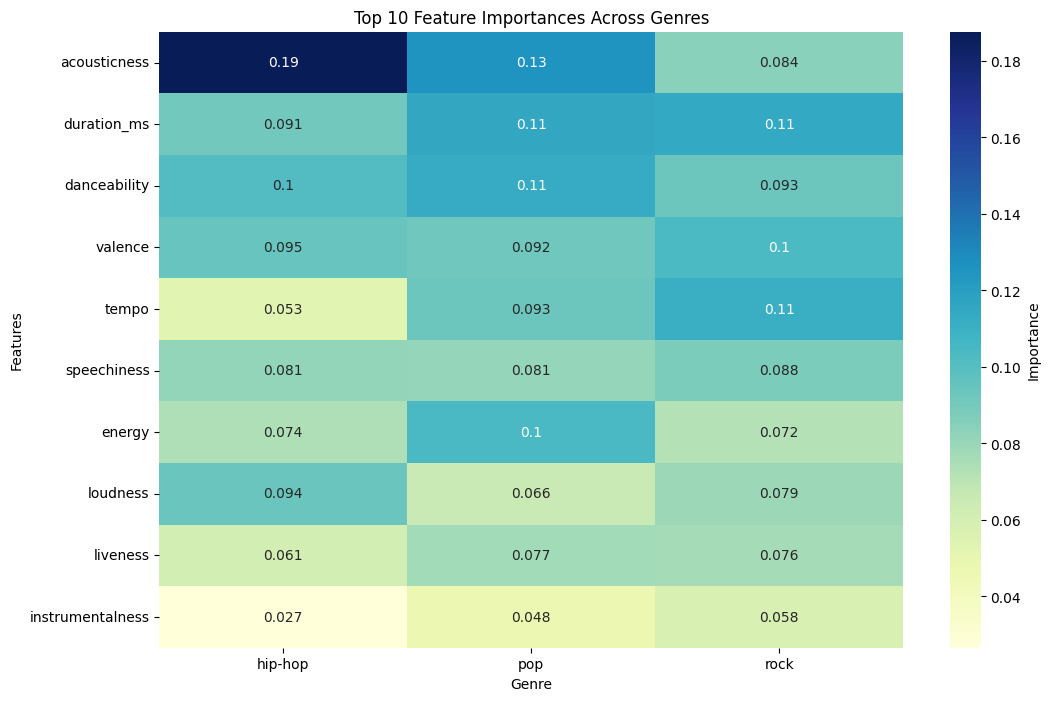

In [ ]:

####TOP 3 GENRES - RANDOM FOREST - TOP FEATURES HEATMAP

all_features_df = pd.DataFrame(feature_importances_by_genre).fillna(0)

# Calculate the top features by taking the mean importance across genres
top_features = all_features_df.mean(axis=1).nlargest(top_n).index
heatmap_data = all_features_df.loc[top_features]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Importance'})
plt.title(f"Top {top_n} Feature Importances Across Genres")
plt.xlabel("Genre")
plt.ylabel("Features")
plt.show()


In [ ]:
#####TOP 3 GENRES - KMEANS
####

# Check for clusters later
n_clusters = 3

kmeans_results_by_genre = {}

for genre in selected_genres:
    # Filter data
    genre_data = data5[data5['track_genre'] == genre]

    X_genre = genre_data.drop(columns=['popularity', 'track_genre'])

    scaler = StandardScaler()
    X_genre_scaled = scaler.fit_transform(X_genre)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_genre_scaled)

    # Store results in the dictionary
    kmeans_results_by_genre[genre] = {
        "labels": kmeans_labels,
        "data": X_genre,  # Original data
        "scaled_data": X_genre_scaled,  # Scaled data
        "centroids": kmeans.cluster_centers_,
    }

    # Add cluster labels back to the genre-specific DataFrame for visualization
    genre_data = genre_data.copy()  # Copy to avoid SettingWithCopyWarning
    genre_data['Cluster'] = kmeans_labels

    # Plot cluster distribution for the genre
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_genre_scaled[:, 0], y=X_genre_scaled[:, 1], hue=kmeans_labels, palette="viridis", s=50)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.title(f"KMeans Clustering for {genre.capitalize()} Genre")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend()
    plt.show()


NameError: name 'selected_genres' is not defined

In [ ]:
import seaborn as sns
import pandas as pd

# Define the top features to include in the pair plot
top_features = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness']

# Create a DataFrame to store data with cluster labels for visualization
genre_clustered_data = []

# Loop through each genre and add cluster labels to the genre data
for genre in selected_genres:
    # Filter data for the current genre
    genre_data = data5[data5['track_genre'] == genre]

    # Define X for the selected top features
    X_genre = genre_data[top_features]

    # Standardize the data
    scaler = StandardScaler()
    X_genre_scaled = scaler.fit_transform(X_genre)

    # Run KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_genre_scaled)

    # Add cluster labels and genre to the DataFrame
    genre_data = genre_data.copy()
    genre_data['Cluster_Label'] = kmeans_labels
    genre_data['Genre'] = genre
    genre_clustered_data.append(genre_data[top_features + ['Cluster_Label', 'Genre']])

# Concatenate all genre data into one DataFrame for pair plot
combined_genre_data = pd.concat(genre_clustered_data)

# Plot
sns.pairplot(combined_genre_data, vars=top_features, hue='Cluster_Label', palette='viridis', corner=True, plot_kws={'alpha':0.6})
plt.suptitle("Pair Plot of Top Features by KMeans Cluster Labels", y=1.02)
plt.show()


NameError: name 'selected_genres' is not defined

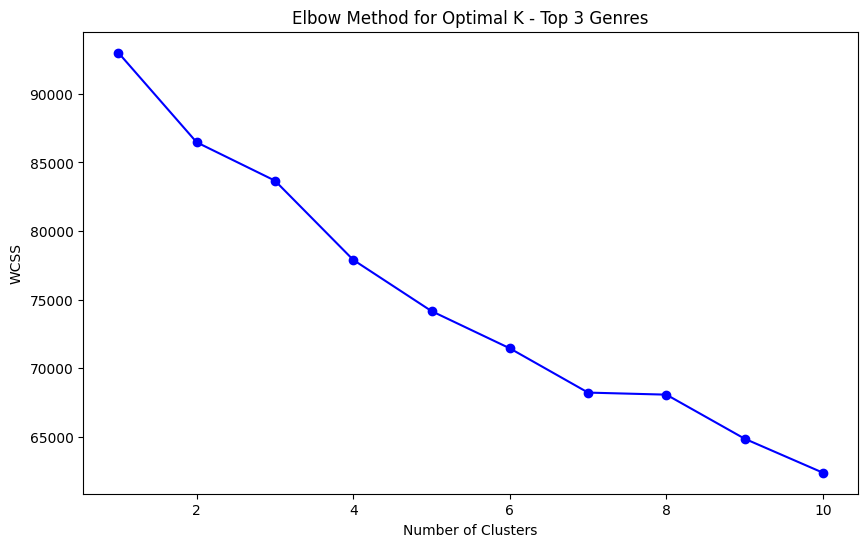

In [ ]:


# Define Top 3 genres for analysis
top_genres_T3 = ['hip-hop', 'pop', 'rock']

# dataset with onlly those genre
data_T3 = data5[data5['track_genre'].isin(top_genres_T3)].copy()

# Dummify
data_T3 = pd.get_dummies(data_T3, columns=['track_genre'])


X_T3 = data_T3
#X_T3 = data_T3.drop(columns=['popularity'])


scaler_T3 = StandardScaler()
X_scaled_T3 = scaler_T3.fit_transform(X_T3)

# Elbow method
wcss_T3 = []
for i in range(1, 11):
    kmeans_T3 = KMeans(n_clusters=i, random_state=42)
    kmeans_T3.fit(X_scaled_T3)
    wcss_T3.append(kmeans_T3.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss_T3, 'bo-')
plt.title('Elbow Method for Optimal K - Top 3 Genres')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()




In [ ]:
###TOP 3 GENRE MERGED - K MEANS
optimal_k_T3 = 3
kmeans_T3 = KMeans(n_clusters=optimal_k_T3, random_state=42)
cluster_labels_T3 = kmeans_T3.fit_predict(X_scaled_T3)

# Add cluster labels to the original data (for analysis purposes)
data_T3['Cluster_Label_T3'] = cluster_labels_T3



,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5,track_genre_hip-hop,track_genre_pop,track_genre_rock,Cluster_Label_T3
51000,83,177391,0.860,0.541,-6.510,0.0325,0.16500,0.163000,0.0663,0.952,114.984,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,2
51001,83,170387,0.768,0.487,-8.936,0.0431,0.24000,0.000000,0.1750,0.722,137.034,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,2
51002,82,148188,0.711,0.702,-10.048,0.2330,0.00487,0.016300,0.0932,0.674,180.219,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,2
51003,77,206060,0.796,0.572,-7.030,0.0545,0.41600,0.000025,0.0975,0.304,98.967,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,2
51004,89,141805,0.591,0.764,-5.484,0.0483,0.03830,0.000000,0.1030,0.478,169.928,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,2


In [ ]:
cluster_means_T3 = data_T3.groupby('Cluster_Label_T3').mean()

# Display the mean values for each cluster
print("Cluster Means (Top 3 Genres):")
print(cluster_means_T3)



NameError: name 'data_T3' is not defined

NameError: name 'silhouette_score' is not defined

In [ ]:
# Add cluster labels to the data
data_T3['Cluster_Label_T3'] = cluster_labels_T3

# Choose top features (or use all) for pairplot
selected_features = ['popularity','duration_ms', 'danceability', 'energy', 'loudness', 'speechiness']
sns.pairplot(data_T3[selected_features + ['Cluster_Label_T3']], hue='Cluster_Label_T3', palette='viridis')
plt.suptitle("Pairplot of Selected Features with Cluster Labels", y=1.02)
plt.show()

NameError: name 'cluster_labels_T3' is not defined

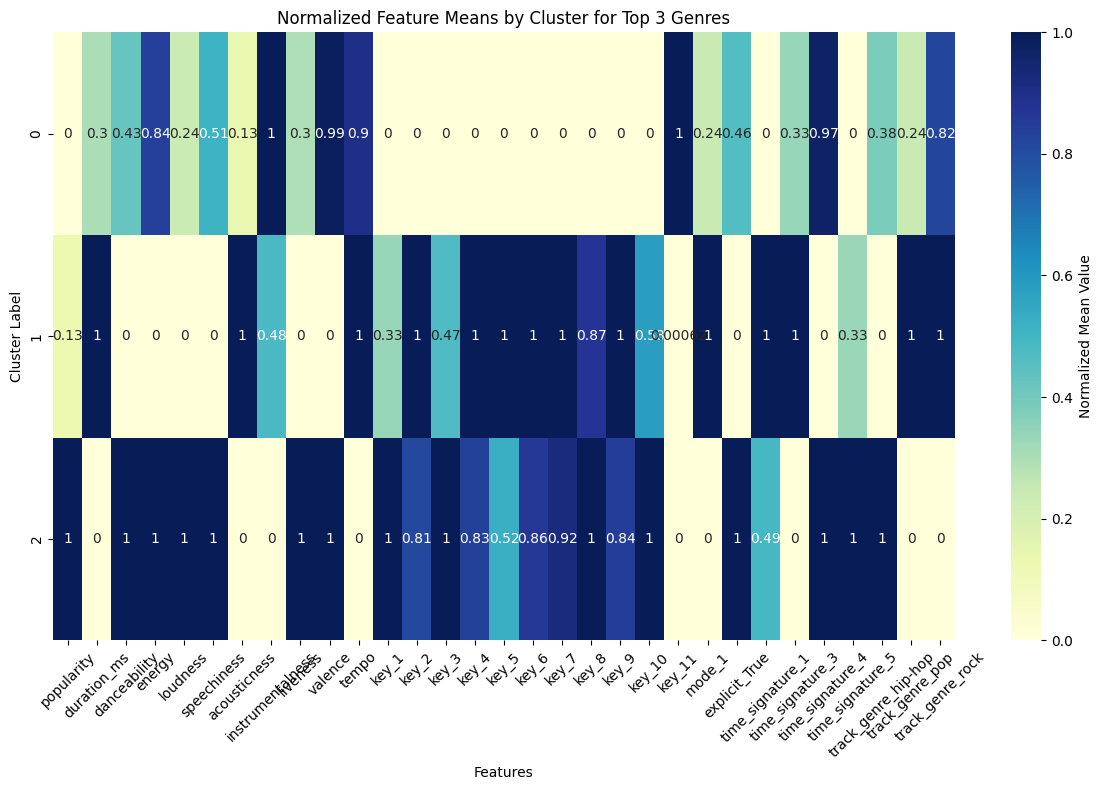

In [ ]:
# scaling data since in the heat map it would only show duration otherwise
scaler = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means_T3),
                                        columns=cluster_means_T3.columns,
                                        index=cluster_means_T3.index)

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_normalized, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Normalized Mean Value'})
plt.title("Normalized Feature Means by Cluster for Top 3 Genres")
plt.xlabel("Features")
plt.ylabel("Cluster Label")
plt.xticks(rotation=45)
plt.tight_layoaut()
plt.show()


In [ ]:
#########################################################################################
#########USING TOP 3 GENRES BASED ON MOST POPULAR IN THIS DATASET########################
 ####RANDOMFOREST FOR TOP 3 GENRES

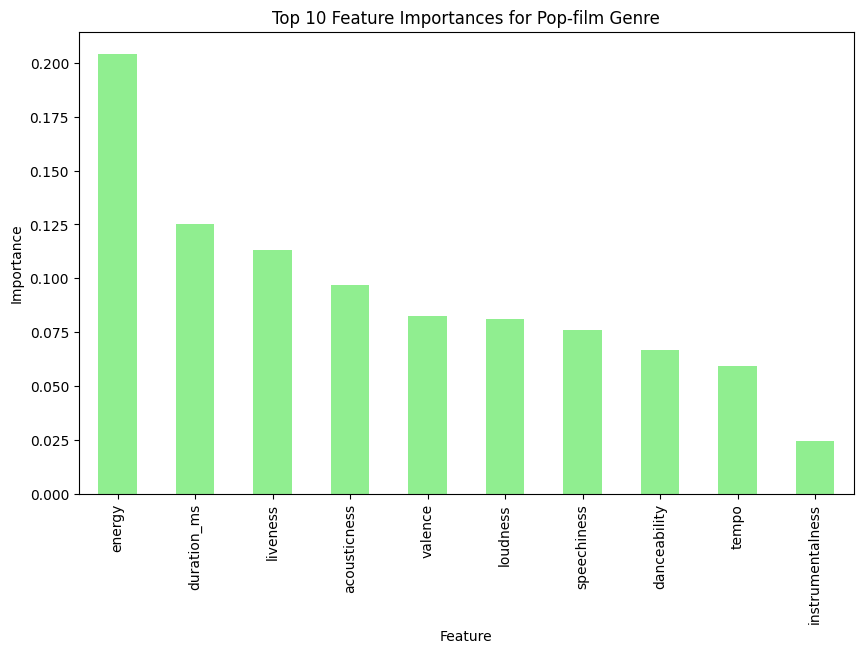

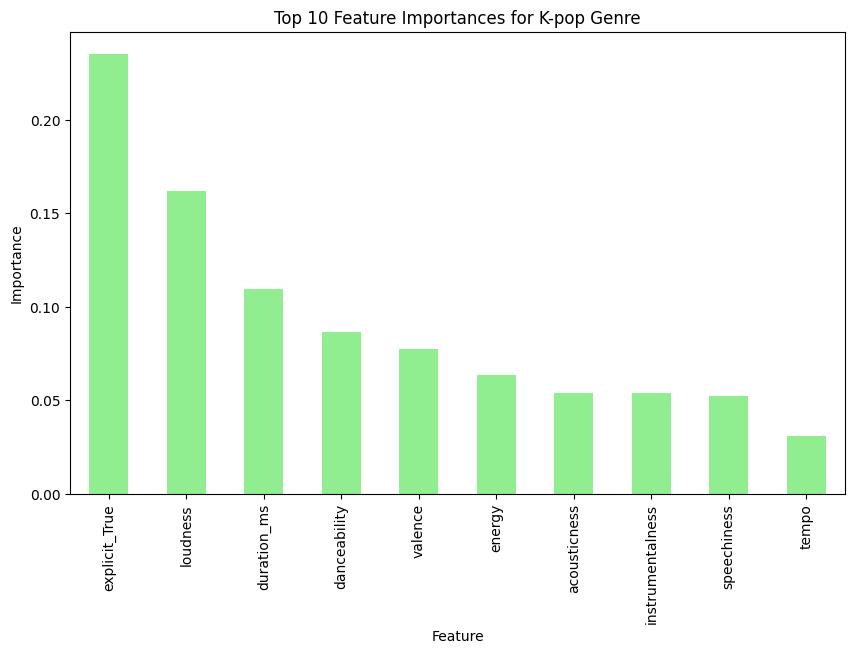

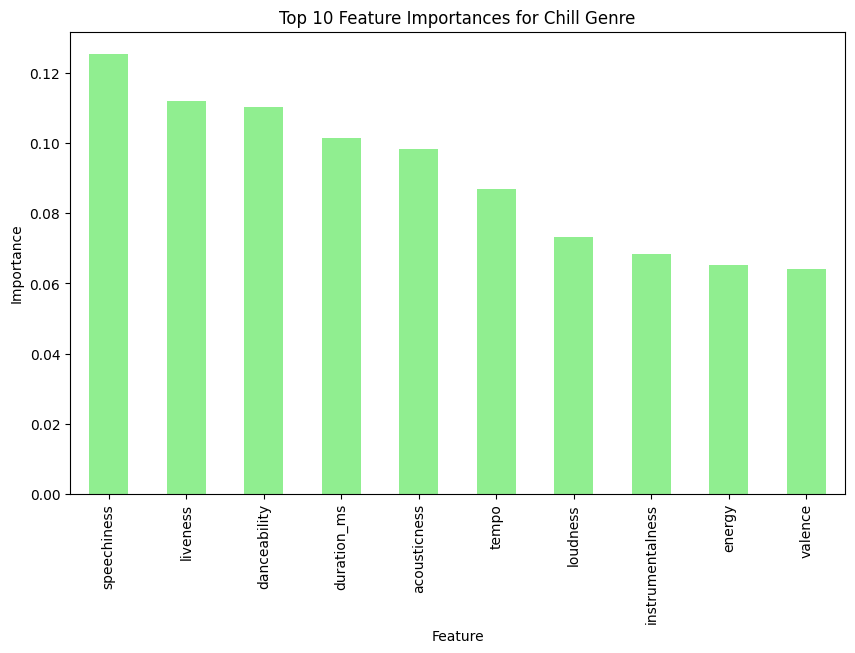

{'pop-film': energy              0.204262
 duration_ms         0.125385
 liveness            0.113047
 acousticness        0.097115
 valence             0.082328
 loudness            0.081270
 speechiness         0.075868
 danceability        0.066627
 tempo               0.059466
 instrumentalness    0.024698
 key_1               0.007397
 key_2               0.006549
 key_11              0.006321
 time_signature_4    0.005416
 key_8               0.005329
 mode_1              0.005060
 key_4               0.004937
 key_5               0.004781
 key_3               0.004538
 key_9               0.004125
 time_signature_1    0.004120
 time_signature_5    0.002591
 key_6               0.002558
 key_10              0.002202
 time_signature_3    0.002186
 key_7               0.001825
 explicit_True       0.000000
 dtype: float64,
 'k-pop': explicit_True       0.235336
 loudness            0.161790
 duration_ms         0.109380
 danceability        0.086297
 valence             0.077573
 e

In [ ]:
 ####RANDOMFOREST FOR TOP 3 GENRES BASED ON THIS DATASET


# Selected genres for analysis
selected_genres_pkc = ['pop-film', 'k-pop', 'chill']


feature_importances_by_genre_pkc = {}

# Loop through each genre, filter data, and calculate feature importance
for genre in selected_genres_pkc:
    # Filter data for the current genre
    genre_data_pkc = data5[data5['track_genre'] == genre]

    # Define X and y
    X_pkc = genre_data_pkc.drop(columns=['popularity', 'track_genre'])  # Drop target and genre columns
    y_pkc = genre_data_pkc['popularity']

    # Split the data into training and test sets
    X_train_pkc, X_test_pkc, y_train_pkc, y_test_pkc = train_test_split(
        X_pkc, y_pkc, test_size=0.2, random_state=42
    )

    # Initialize and train the random forest model
    rf_model_pkc = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_pkc.fit(X_train_pkc, y_train_pkc)

    # Calculate feature importances and store them
    feature_importances_pkc = pd.Series(rf_model_pkc.feature_importances_, index=X_pkc.columns)
    feature_importances_by_genre_pkc[genre] = feature_importances_pkc.sort_values(ascending=False)

    # Plot top 10 features for the current genre
    plt.figure(figsize=(10, 6))
    feature_importances_pkc.sort_values(ascending=False).head(10).plot(kind='bar', color='lightgreen')  # Sort here
    plt.title(f"Top 10 Feature Importances for {genre.capitalize()} Genre")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

# Display feature importances for each genre
feature_importances_by_genre_pkc

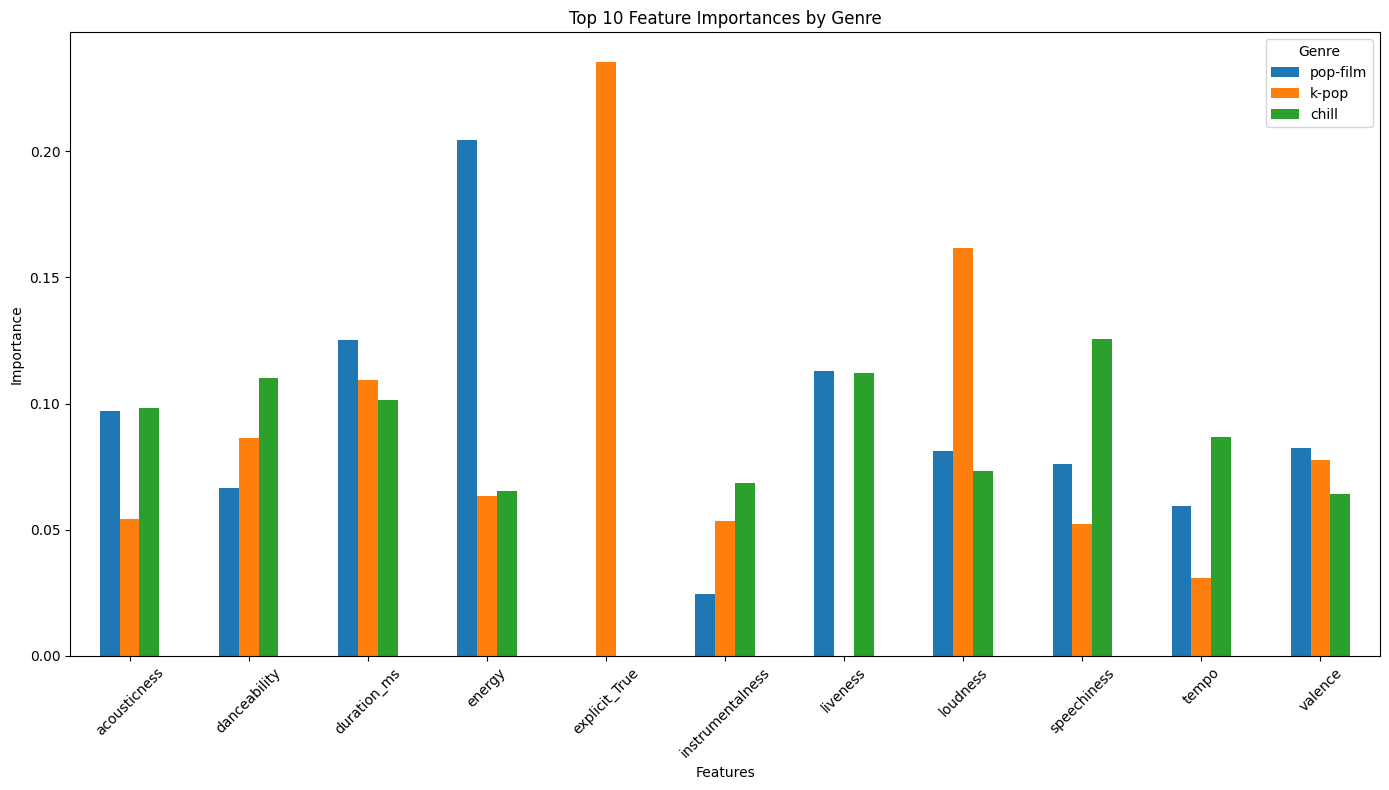

In [ ]:
####TOP 3 GENRES RANDOM FOREST - TOP FEATURES COMPARISON
##BASED ON DATASET
top_n = 10


top_features_df = pd.DataFrame({
    genre: feature_importances_by_genre[genre].head(top_n)
    for genre in selected_genres
})

# plot
top_features_df.plot(kind='bar', figsize=(14, 8))
plt.title(f"Top {top_n} Feature Importances by Genre")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.legend(title="Genre")
plt.tight_layout()
plt.show()



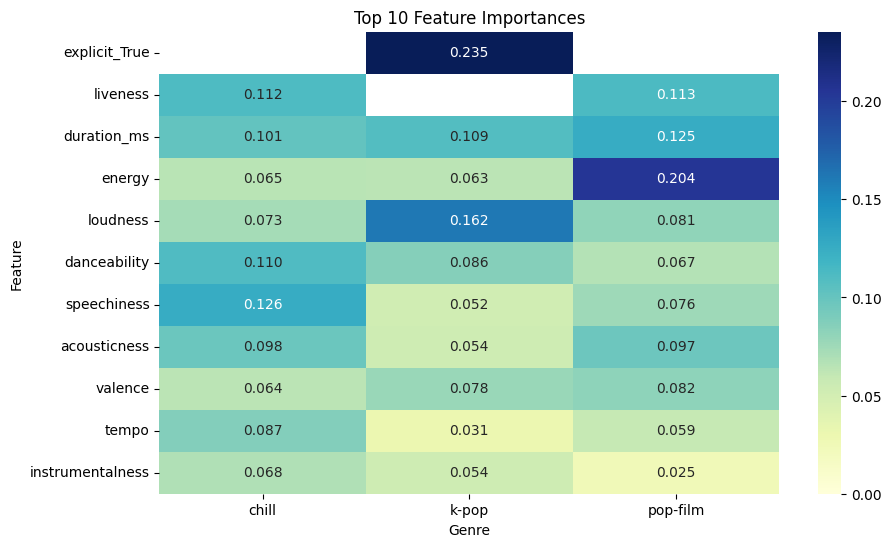

In [ ]:
top_n = 10
top_features_df = pd.DataFrame({
    genre: feature_importances_by_genre[genre].head(top_n)
    for genre in selected_genres
})
combined_importances_pkc['mean_importance'] = combined_importances_pkc.mean(axis=1)
combined_importances_pkc = combined_importances_pkc.sort_values(by='mean_importance', ascending=False)
combined_importances_pkc = combined_importances_pkc.drop('mean_importance', axis=1)

# Create the heatmap (only once)
plt.figure(figsize=(10, 6))
sns.heatmap(combined_importances_pkc, annot=True, cmap="YlGnBu", fmt=".3f",
            vmin=0, vmax=combined_importances_pkc.max().max())

# Add title and labels
plt.title("Top 10 Feature Importances")
plt.xlabel("Genre")
plt.ylabel("Feature")

plt.show()

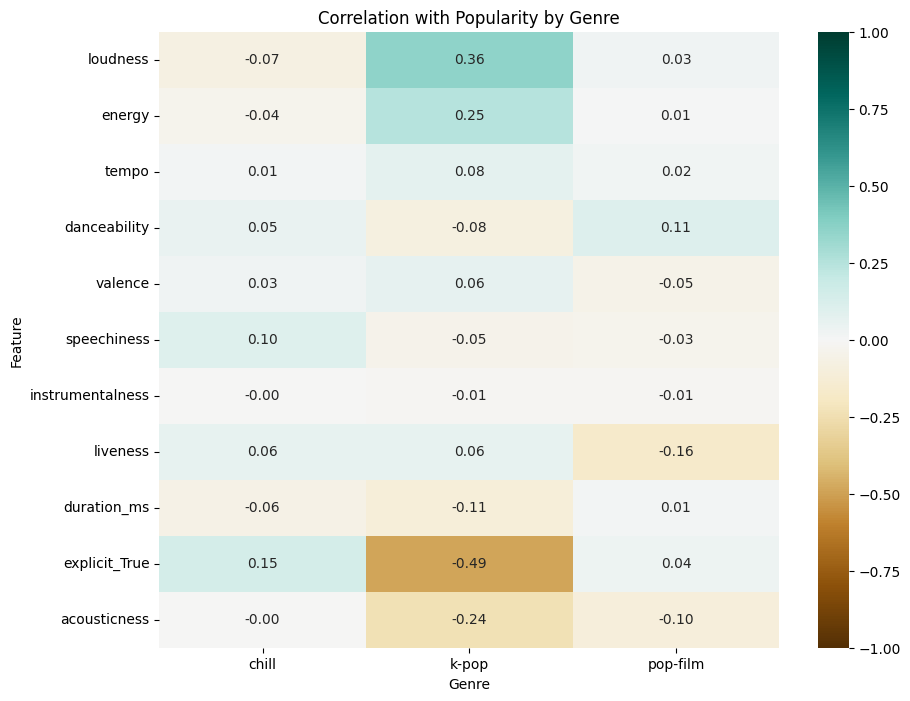

In [ ]:
top_features_by_genre = {
    'chill': ['speechiness', 'liveness', 'danceability', 'duration_ms', 'acousticness',
              'tempo', 'loudness', 'instrumentalness', 'energy', 'valence'],
    'k-pop': ['explicit_True', 'loudness', 'duration_ms', 'danceability', 'valence',
              'energy', 'acousticness', 'instrumentalness', 'speechiness', 'tempo'],
    'pop-film': ['energy', 'duration_ms', 'liveness', 'acousticness', 'valence',
                 'loudness', 'speechiness', 'danceability', 'tempo', 'instrumentalness']
}

# Combine all unique features
all_features = []
for features in top_features_by_genre.values():
    all_features.extend(features)
all_features = list(set(all_features))

# Calculate correlation matrices for each genre
correlation_matrices = {}
for genre, features in top_features_by_genre.items():
    genre_data = data5[data5['track_genre'] == genre]
    correlation_matrices[genre] = genre_data[['popularity'] + all_features].corr()

# Create a consolidated correlation matrix with genres as columns
consolidated_corr_df = pd.DataFrame()
for genre, corr_matrix in correlation_matrices.items():
    consolidated_corr_df[genre] = corr_matrix['popularity'].drop('popularity')
consolidated_corr_df.index = all_features

# Calculate the mean correlation for each feature
consolidated_corr_df['mean_correlation'] = consolidated_corr_df.mean(axis=1)

# Sort the DataFrame by mean correlation
consolidated_corr_df = consolidated_corr_df.sort_values(by='mean_correlation', ascending=False)

# Remove the temporary 'mean_correlation' column
consolidated_corr_df = consolidated_corr_df.drop('mean_correlation', axis=1)

# Create the heatmap with green for positive correlations
plt.figure(figsize=(10, 8))
sns.heatmap(consolidated_corr_df, annot=True, cmap="BrBG", fmt=".2f",  # Use the BrBG colormap
            vmin=-1, vmax=1)
plt.title('Correlation with Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Feature')
plt.show()

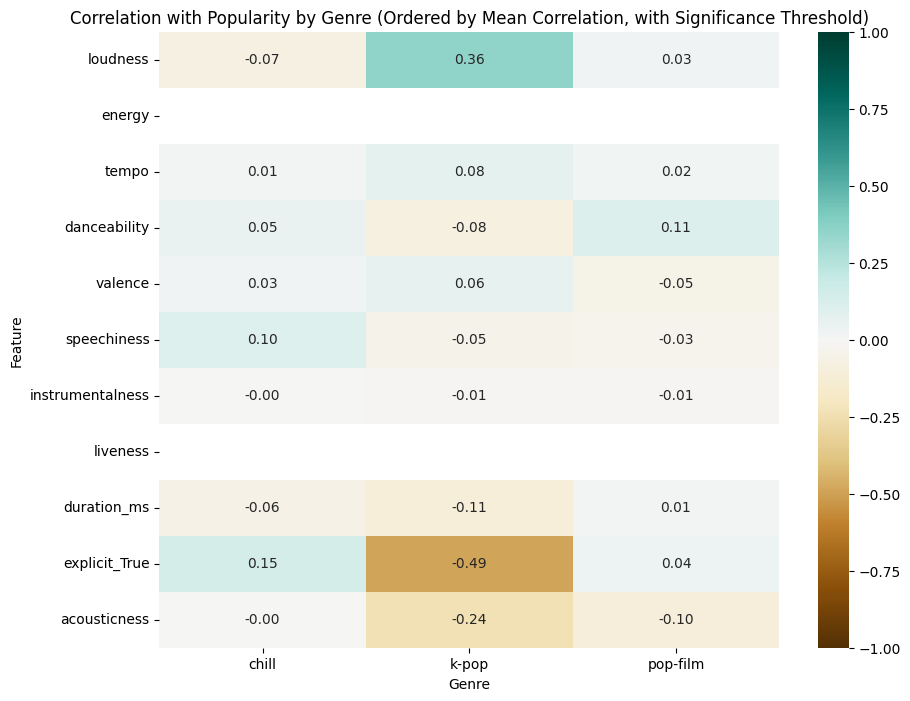

In [ ]:
# Assuming you have a DataFrame called 'data5' with your music data

# Top 10 features for each genre
top_features_by_genre = {
    'chill': ['speechiness', 'liveness', 'danceability', 'duration_ms', 'acousticness',
              'tempo', 'loudness', 'instrumentalness', 'energy', 'valence'],
    'k-pop': ['explicit_True', 'loudness', 'duration_ms', 'danceability', 'valence',
              'energy', 'acousticness', 'instrumentalness', 'speechiness', 'tempo'],
    'pop-film': ['energy', 'duration_ms', 'liveness', 'acousticness', 'valence',
                 'loudness', 'speechiness', 'danceability', 'tempo', 'instrumentalness']
}

# Combine all unique features
all_features = []
for features in top_features_by_genre.values():
    all_features.extend(features)
all_features = list(set(all_features))

# Calculate correlation matrices for each genre
correlation_matrices = {}
for genre, features in top_features_by_genre.items():
    genre_data = data5[data5['track_genre'] == genre]
    correlation_matrices[genre] = genre_data[['popularity'] + all_features].corr()

# Create a consolidated correlation matrix with genres as columns
consolidated_corr_df = pd.DataFrame()
for genre, corr_matrix in correlation_matrices.items():
    consolidated_corr_df[genre] = corr_matrix['popularity'].drop('popularity')
consolidated_corr_df.index = all_features

# Calculate the mean correlation for each feature
consolidated_corr_df['mean_correlation'] = consolidated_corr_df.mean(axis=1)

# Sort the DataFrame by mean correlation
consolidated_corr_df = consolidated_corr_df.sort_values(by='mean_correlation', ascending=False)

# Remove the temporary 'mean_correlation' column
consolidated_corr_df = consolidated_corr_df.drop('mean_correlation', axis=1)

# Calculate p-values for the correlations
p_values = consolidated_corr_df.apply(lambda col: [pearsonr(data5[col.name], data5['popularity'])[1] for col.name in col.index])

# Set non-significant correlations (p >= 0.05) to NaN
consolidated_corr_df[p_values >= 0.05] = np.nan

# Create the heatmap with green for positive correlations and thresholding
plt.figure(figsize=(10, 8))
sns.heatmap(consolidated_corr_df, annot=True, cmap="BrBG", fmt=".2f",
            vmin=-1, vmax=1)
plt.title('Correlation with Popularity by Genre (Ordered by Mean Correlation, with Significance Threshold)')
plt.xlabel('Genre')
plt.ylabel('Feature')
plt.show()

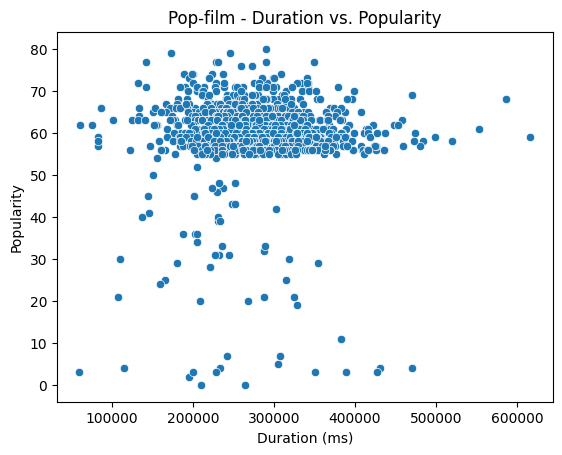

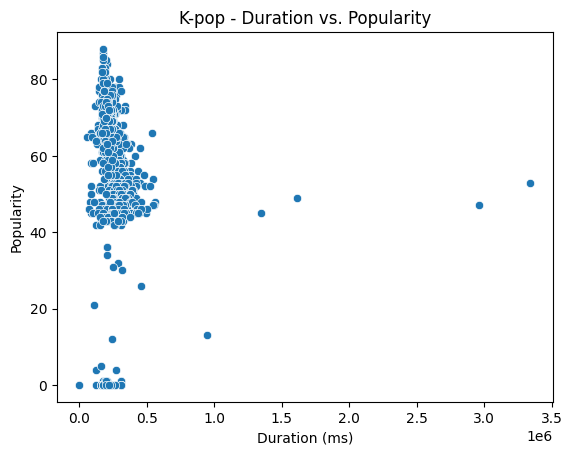

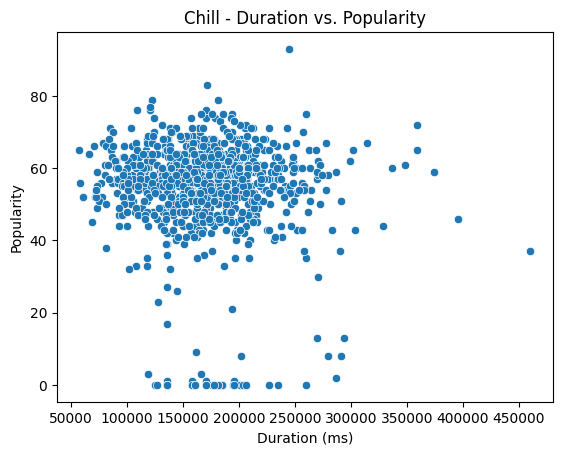

In [ ]:
genres = ['pop-film', 'k-pop', 'chill']

for genre in genres:
    genre_data = data5[data5['track_genre'] == genre]

    plt.figure()  # Create a new figure for each genre
    sns.scatterplot(x='duration_ms', y='popularity', data=genre_data)
    plt.xlabel('Duration (ms)')
    plt.ylabel('Popularity')
    plt.title(f'{genre.capitalize()} - Duration vs. Popularity')
    plt.show()

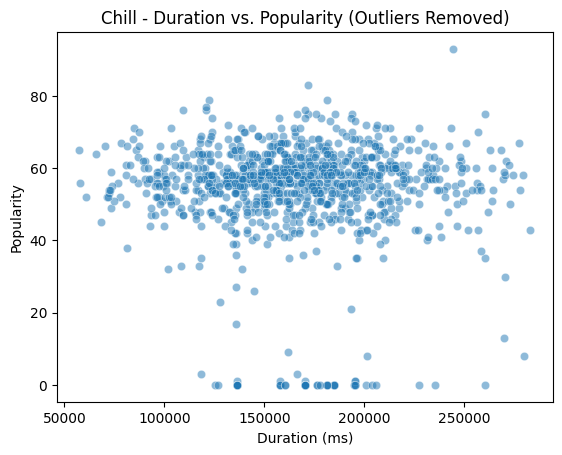

In [ ]:

# Assuming you have your data in a DataFrame called 'data5'

genre = 'chill'
genre_data = data5[data5['track_genre'] == genre]

# Remove outliers (example using IQR method)
Q1 = genre_data['duration_ms'].quantile(0.25)
Q3 = genre_data['duration_ms'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = genre_data[(genre_data['duration_ms'] >= lower_bound) & (genre_data['duration_ms'] <= upper_bound)]

plt.figure()
sns.scatterplot(x='duration_ms', y='popularity', data=filtered_data, alpha=0.5)  # Add transparency
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.title(f'{genre.capitalize()} - Duration vs. Popularity (Outliers Removed)')
plt.show()

Correlations for k-pop: {'explicit_True': -0.5007695410875856, 'loudness': 0.35332795382477566, 'duration_ms': -0.1867435968716914, 'danceability': -0.1066216302054621, 'valence': 0.07322926225068346, 'energy': 0.24363107458312738, 'acousticness': -0.222627384347679, 'instrumentalness': -0.014474456464367383, 'speechiness': -0.06058620509487595, 'tempo': 0.06839701247548235}
Optimal duration for K-pop: 186445.32 ms


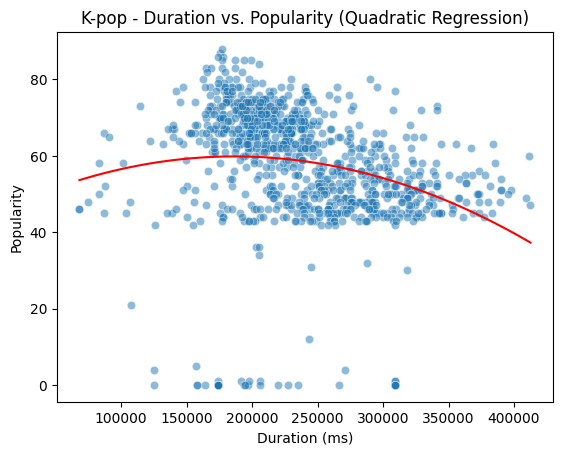

In [ ]:
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assuming you have your data in a DataFrame called 'data5'
# and top_features_by_genre dictionary with top 10 features

genre = 'k-pop'
genre_data = data5[data5['track_genre'] == genre]
features = top_features_by_genre[genre]

# Remove outliers (example using IQR method)
Q1 = genre_data['duration_ms'].quantile(0.25)
Q3 = genre_data['duration_ms'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = genre_data[(genre_data['duration_ms'] >= lower_bound) & (genre_data['duration_ms'] <= upper_bound)]

# Correlation analysis
correlations = {}
for feature in features:
    corr, _ = pearsonr(filtered_data[feature], filtered_data['popularity'])
    correlations[feature] = corr

print(f"Correlations for {genre}:", correlations)

Q1 = genre_data['duration_ms'].quantile(0.25)
Q3 = genre_data['duration_ms'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = genre_data[(genre_data['duration_ms'] >= lower_bound) & (genre_data['duration_ms'] <= upper_bound)]

X = filtered_data['duration_ms'].values.reshape(-1, 1)
y = filtered_data['popularity']

poly = PolynomialFeatures(degree=2)  # Create polynomial features for quadratic regression
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for a range of durations
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_pred = model.predict(X_range_poly)

# Find the optimal duration
optimal_duration = X_range[np.argmax(y_pred)][0]  # Get duration with maximum predicted popularity
print(f'Optimal duration for K-pop: {optimal_duration:.2f} ms')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.scatterplot(x='duration_ms', y='popularity', data=filtered_data, alpha=0.5)
plt.plot(X_range, y_pred, color='red')  # Plot the regression curve
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.title(f'K-pop - Duration vs. Popularity (Quadratic Regression)')
plt.show()


R-squared for K-pop quadratic model: 0.050


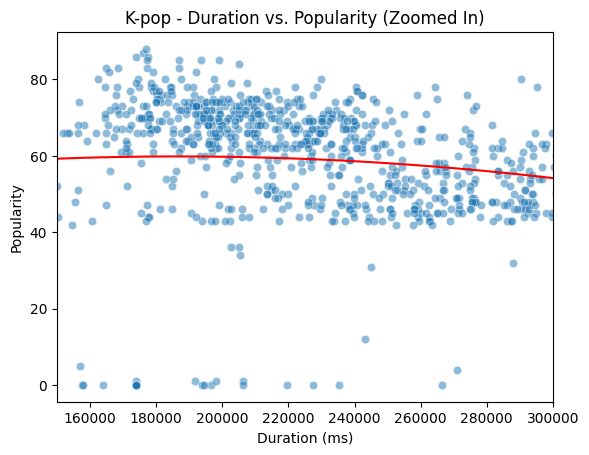

In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y, model.predict(X_poly))
print(f'R-squared for K-pop quadratic model: {r2:.3f}')

# Zoom in on the plot
plt.figure()
sns.scatterplot(x='duration_ms', y='popularity', data=filtered_data, alpha=0.5)
plt.plot(X_range, y_pred, color='red')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.title(f'K-pop - Duration vs. Popularity (Zoomed In)')
plt.xlim(150000, 300000)  # Set x-axis limits to zoom in
plt.show()

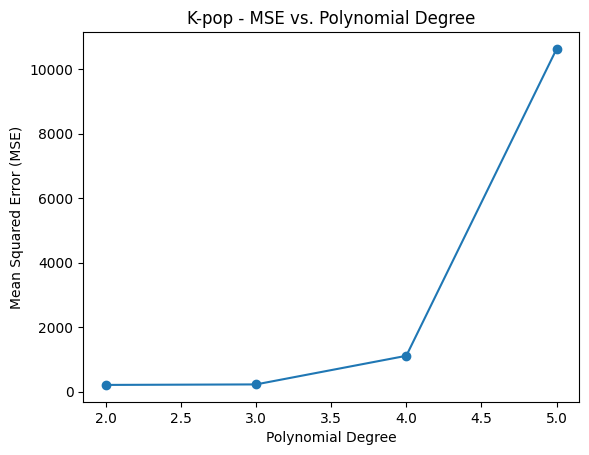

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Assuming you have your data in a DataFrame called 'data5'
# and top_features_by_genre dictionary with top 10 features for each genre

genre = 'k-pop'
max_degree = 5  # Maximum polynomial degree to test

genre_data = data5[data5['track_genre'] == genre]
features = top_features_by_genre[genre]
X = genre_data[features]
y = genre_data['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mse_values = []
for degree in range(2, max_degree + 1):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)

    mse_values.append(mse)

# Plot MSE vs. degree
plt.figure()
plt.plot(range(2, max_degree + 1), mse_values, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'{genre.capitalize()} - MSE vs. Polynomial Degree')
plt.show()

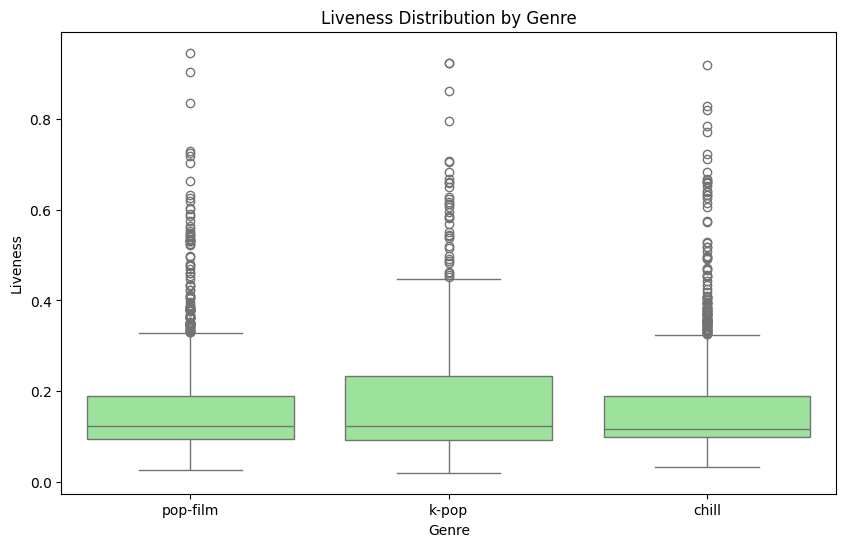

In [ ]:
genres = ['pop-film', 'k-pop', 'chill']

plt.figure(figsize=(10, 6))

sns.boxplot(x='track_genre', y='liveness', data=data5, order=genres, color='lightgreen')

plt.xlabel('Genre')
plt.ylabel('Liveness')
plt.title('Liveness Distribution by Genre')

# Extract and print the median, Q1, and Q3 values
for genre in genres:
    genre_data = data5[data5['track_genre'] == genre]['liveness']
    median = genre_data.median()
    q1 = genre_data.quantile(0.25)
    q3 = genre_data.quantile(0.75)
    print(f"{genre}: Median = {median:.3f}, Q1 = {q1:.3f}, Q3 = {q3:.3f}")

plt.show()


In [ ]:

###boxplot for durationxgenre
genres = ['pop-film', 'k-pop', 'chill']

plt.figure(figsize=(10, 5))

# Create the boxplot with a logarithmic y-scale
sns.boxplot(x='track_genre', y='duration_ms', data=data5, order=genres, color='lightgreen')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.xlabel('Genre')
plt.ylabel('Duration (ms) - Log Scale')
plt.title('Duration Distribution by Genre')
plt.show()



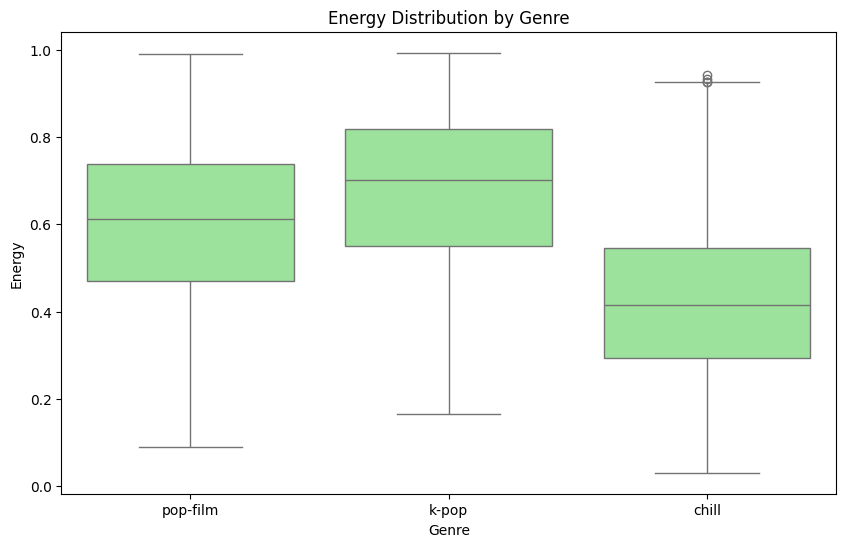

In [ ]:

###energy
genres = ['pop-film', 'k-pop', 'chill']

plt.figure(figsize=(10, 6))

sns.boxplot(x='track_genre', y='energy', data=data5, order=genres, color='lightgreen')

plt.xlabel('Genre')
plt.ylabel('Energy')
plt.title('Energy Distribution by Genre')
plt.show()

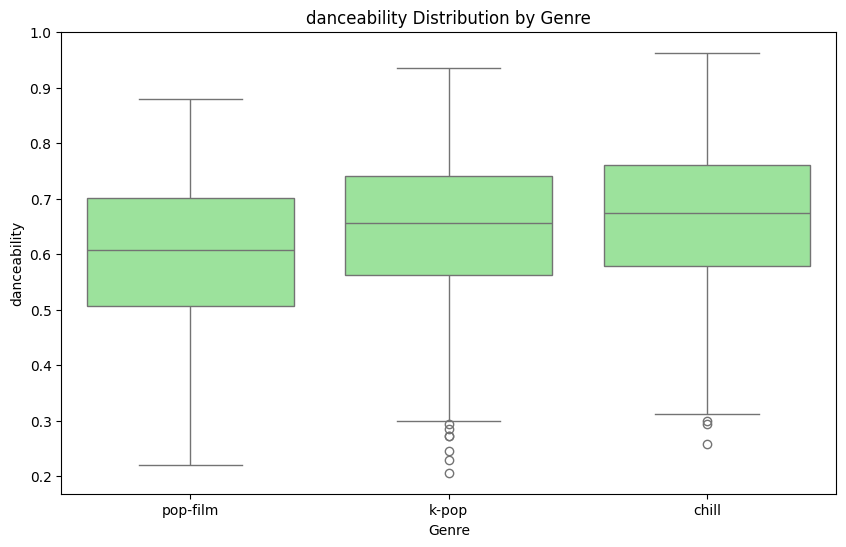

In [ ]:

###energy
genres = ['pop-film', 'k-pop', 'chill']

plt.figure(figsize=(10, 6))

sns.boxplot(x='track_genre', y='danceability', data=data5, order=genres, color='lightgreen')

plt.xlabel('Genre')
plt.ylabel('danceability')
plt.title('danceability Distribution by Genre')
plt.show()